In [1]:
import pandas as pd 
import sklearn 
import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn import metrics
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

pd.options.mode.chained_assignment = None  # default='warn'

2023-03-05 19:11:12.460038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
sns.set(context='talk', style='white', rc={'figure.facecolor':'white'}, font_scale=1)
sns.set_style('ticks')

In [3]:
all_files = glob.glob("*/RNA-seq/*.txt")

In [4]:
sample_id_list = []
trimester_list = []

for file in all_files: 
    if file.split("/")[0] == 'Preeclampsia':
        trimester = file.split("/")[-1].split("_")[4].split(".")[0]
        sample_name = file.split("/")[-1].split("_")[0]
    else:
        trimester = file.split("/")[-1].split("_")[3].split(".")[0]
        sample_name = file.split("/")[-1].split("_")[0]
    sample_id_list.append(sample_name)
    trimester_list.append(trimester)

In [5]:
trimester_and_sample_id = pd.DataFrame(zip(sample_id_list, trimester_list), columns=["id", "trimester"])
trimester_and_sample_id

,id,trimester
0,GSM4669998,2ndT
1,GSM4669996,cordB
2,GSM4669992,1stT
3,GSM4670007,1stT
4,GSM4669988,2ndT
...,...,...
122,GSM4670018,2ndT
123,GSM4670012,1stT
124,GSM4670019,3rdT
125,GSM4670021,cordB


In [6]:
## expression_df[firstT_ids]
read_counts = pd.read_csv("read_count_data.txt", sep="\t")
read_counts = read_counts.T
read_counts

,0,1,2,3,4,5,6,7,8,9,...,57726,57727,57728,57729,57730,57731,57732,57733,57734,57735
GSM4669998,3,9,0,0,0,0,0,0,0,0,...,172,0,45,3,0,0,0,135,0,0
GSM4669996,0,0,0,0,0,0,0,0,0,0,...,240,0,50,0,0,1,13,179,3,0
GSM4669992,0,1,0,0,0,0,0,0,0,0,...,63,0,17,0,0,0,7,132,1,0
GSM4670007,6,0,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,47,0,0
GSM4669988,19,0,0,0,0,0,0,0,0,0,...,49,0,41,0,0,0,0,20,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSM4670018,0,0,0,0,11,2,0,0,0,0,...,79,1,16,0,0,0,2,90,0,0
GSM4670012,0,4,0,0,0,0,0,0,0,0,...,46,0,75,0,0,0,30,134,0,0
GSM4670019,0,2,0,0,3,1,0,2,0,0,...,114,0,30,0,0,0,5,139,3,0
GSM4670021,0,2,0,0,0,0,0,0,0,0,...,230,3,43,1,0,0,8,175,1,0


In [7]:
# read_counts_with_diseases = pd.read_csv("read_counts_with_diseases.txt", sep="\t")
# read_counts.index = read_counts_with_diseases.index
# read_counts["disease"] = read_counts_with_diseases["phenotype"]
# read_counts.index = trimester_and_sample_id.index
# read_counts["trimester"] = trimester_and_sample_id["trimester"]
read_counts = pd.read_csv("read_counts_with_diseases_and_trimester.txt", sep="\t")
read_counts

,0,1,2,3,4,5,6,7,8,9,...,57728,57729,57730,57731,57732,57733,57734,57735,disease,trimester
0,3,9,0,0,0,0,0,0,0,0,...,45,3,0,0,0,135,0,0,Preeclampsia,2ndT
1,0,0,0,0,0,0,0,0,0,0,...,50,0,0,1,13,179,3,0,Preeclampsia,cordB
2,0,1,0,0,0,0,0,0,0,0,...,17,0,0,0,7,132,1,0,Preeclampsia,1stT
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,47,0,0,Preeclampsia,1stT
4,19,0,0,0,0,0,0,0,0,0,...,41,0,0,0,0,20,0,0,Preeclampsia,2ndT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,0,0,0,0,11,2,0,0,0,0,...,16,0,0,0,2,90,0,0,Chronic-Hypertension,2ndT
130,0,4,0,0,0,0,0,0,0,0,...,75,0,0,0,30,134,0,0,Chronic-Hypertension,1stT
131,0,2,0,0,3,1,0,2,0,0,...,30,0,0,0,5,139,3,0,Chronic-Hypertension,3rdT
132,0,2,0,0,0,0,0,0,0,0,...,43,1,0,0,8,175,1,0,Chronic-Hypertension,cordB


# Trimester 1 data prep

In [8]:
genes = pd.read_csv("genes.txt", sep="\t")
genes = genes.T
genes["disease"] = "n/a"
genes = genes.T
genes.to_csv("gene_transcripts.txt", index=False, sep="\t")
genes

## add this in the table to figure out which one is the most differentially expressed
## diffe code below

,transcript
0,ENSG00000223972
1,ENSG00000227232
2,ENSG00000243485
3,ENSG00000237613
4,ENSG00000268020
...,...
57732,ENSG00000160307
57733,ENSG00000160310
57734,ENSG00000230982
57735,ENSG00000212932


In [9]:
first_trimester_data = read_counts.loc[read_counts["trimester"] == "1stT"]
first_trimester_data.drop("trimester", axis=1, inplace=True)
first_trimester_data

,0,1,2,3,4,5,6,7,8,9,...,57727,57728,57729,57730,57731,57732,57733,57734,57735,disease
2,0,1,0,0,0,0,0,0,0,0,...,0,17,0,0,0,7,132,1,0,Preeclampsia
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,47,0,0,Preeclampsia
5,1,1,0,0,6,0,0,0,0,0,...,0,13,2,0,0,2,76,0,0,Preeclampsia
9,1,0,0,0,0,0,0,0,0,0,...,0,47,0,0,0,0,30,0,0,Preeclampsia
20,0,0,0,0,0,0,0,0,0,0,...,0,28,0,0,0,10,111,11,0,Preeclampsia
22,0,2,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,65,0,0,Preeclampsia
25,0,0,0,0,3,0,0,0,0,0,...,0,26,0,0,0,0,160,0,0,Preeclampsia
27,0,0,0,0,0,0,0,0,0,0,...,0,11,0,0,0,0,83,0,0,Preeclampsia
43,0,5,0,0,0,0,0,0,0,1,...,0,24,0,0,0,0,65,0,0,Gestational-Diabetes
44,11,0,0,0,0,0,0,0,0,0,...,0,36,0,0,0,4,95,1,0,Gestational-Diabetes


In [10]:
first_trimester_data_copy = first_trimester_data.drop("disease", axis=1)
first_trimester_data_copy = first_trimester_data_copy.T
first_trimester_data_copy.to_csv("first_trimester_data.txt", index=False, sep="\t")
first_trimester_data_copy

## trying to redo differential expression analysis in R with only first trimester data

,2,3,5,9,20,22,25,27,43,44,...,83,89,92,99,108,114,117,118,124,130
0,0,6,1,1,0,0,0,0,0,11,...,0,0,0,0,0,31,31,0,0,0
1,1,0,1,0,0,2,0,0,5,0,...,0,0,0,0,1,0,2,0,0,4
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,6,0,0,0,3,0,0,0,...,0,0,0,5,1,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57731,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
57732,7,0,2,0,10,0,0,0,0,4,...,28,0,0,3,4,34,10,18,8,30
57733,132,47,76,30,111,65,160,83,65,95,...,371,146,44,121,153,251,577,116,73,134
57734,1,0,0,0,11,0,0,0,0,1,...,8,0,0,8,0,8,13,0,4,0


In [11]:
first_trimester_diseases = first_trimester_data["disease"]
first_trimester_diseases.to_csv("first_trimester_diseases.txt", index=False, sep="\t")
first_trimester_diseases

2              Preeclampsia
3              Preeclampsia
5              Preeclampsia
9              Preeclampsia
20             Preeclampsia
22             Preeclampsia
25             Preeclampsia
27             Preeclampsia
43     Gestational-Diabetes
44     Gestational-Diabetes
49     Gestational-Diabetes
56     Gestational-Diabetes
66     Gestational-Diabetes
70     Gestational-Diabetes
71     Gestational-Diabetes
83         Normal-Pregnancy
89         Normal-Pregnancy
92         Normal-Pregnancy
99         Normal-Pregnancy
108        Normal-Pregnancy
114        Normal-Pregnancy
117        Normal-Pregnancy
118        Normal-Pregnancy
124    Chronic-Hypertension
130    Chronic-Hypertension
Name: disease, dtype: object

# Preeclampsia Trimester 1

## case: preeclampsia control: healthy pregnancy

In [12]:
## case: pregnancy complications (all diseases) control: healthy pregnancy## lasso regression with a table containing preeclampsia and normal samples during the first trimester
first_trimester_data["preeclampsia"] = np.where(first_trimester_data.disease.str.contains("Preeclampsia"), 1, 0)
preeclampsia_firstT = first_trimester_data[(first_trimester_data.disease == "Normal-Pregnancy")| (first_trimester_data.disease == "Preeclampsia")]
preeclampsia_firstT = preeclampsia_firstT.drop(["disease"], axis=1)
preeclampsia_firstT

,0,1,2,3,4,5,6,7,8,9,...,57727,57728,57729,57730,57731,57732,57733,57734,57735,preeclampsia
2,0,1,0,0,0,0,0,0,0,0,...,0,17,0,0,0,7,132,1,0,1
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,47,0,0,1
5,1,1,0,0,6,0,0,0,0,0,...,0,13,2,0,0,2,76,0,0,1
9,1,0,0,0,0,0,0,0,0,0,...,0,47,0,0,0,0,30,0,0,1
20,0,0,0,0,0,0,0,0,0,0,...,0,28,0,0,0,10,111,11,0,1
22,0,2,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,65,0,0,1
25,0,0,0,0,3,0,0,0,0,0,...,0,26,0,0,0,0,160,0,0,1
27,0,0,0,0,0,0,0,0,0,0,...,0,11,0,0,0,0,83,0,0,1
83,0,0,0,0,0,0,0,0,0,1,...,0,224,0,0,0,28,371,8,0,0
89,0,0,0,0,0,0,0,0,0,0,...,0,8,0,0,0,0,146,0,0,0


In [13]:
preeclampsia_firstT_diffe = preeclampsia_firstT

## binary lasso model

In [14]:
X = preeclampsia_firstT_diffe.loc[:, preeclampsia_firstT_diffe.columns != "preeclampsia"] # use all columns that aren't the outcome for input
Y = preeclampsia_firstT_diffe["preeclampsia"] # use the binary outcome column for Y 

In [15]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

In [16]:
preeclampsia_firstT_model = LogisticRegression(penalty='l1', solver='liblinear')
preeclampsia_firstT_model.fit(x_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [17]:
predictions = preeclampsia_firstT_model.predict(x_test) # we then test it on our held out data

In [18]:
accuracy_score(y_test, predictions)

0.75

In [19]:
mean_squared_error(y_test, predictions)

0.25

## top lasso genes

In [20]:
# the coefficients for the input variables (0 means not used for the task)
preeclampsia_firstT_model.coef_

array([[0., 0., 0., ..., 0., 0., 0.]])

In [22]:
first_trimester_data_transcripts = first_trimester_data.drop(["disease"], axis=1)
first_trimester_data_transcripts = first_trimester_data_transcripts.T
first_trimester_data_transcripts = pd.concat([first_trimester_data_transcripts.reset_index(drop=True), genes["transcript"].reset_index(drop=True)], axis=1)
first_trimester_data_transcripts = first_trimester_data_transcripts.drop(57736)
first_trimester_data_transcripts = first_trimester_data_transcripts.T
first_trimester_data_transcripts

,0,1,2,3,4,5,6,7,8,9,...,57726,57727,57728,57729,57730,57731,57732,57733,57734,57735
2,0,1,0,0,0,0,0,0,0,0,...,63,0,17,0,0,0,7,132,1,0
3,6,0,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,47,0,0
5,1,1,0,0,6,0,0,0,0,0,...,35,0,13,2,0,0,2,76,0,0
9,1,0,0,0,0,0,0,0,0,0,...,19,0,47,0,0,0,0,30,0,0
20,0,0,0,0,0,0,0,0,0,0,...,49,0,28,0,0,0,10,111,11,0
22,0,2,0,0,0,0,0,0,0,0,...,136,0,4,0,0,0,0,65,0,0
25,0,0,0,0,3,0,0,0,0,0,...,62,0,26,0,0,0,0,160,0,0
27,0,0,0,0,0,0,0,0,0,0,...,44,0,11,0,0,0,0,83,0,0
43,0,5,0,0,0,0,0,0,0,1,...,104,0,24,0,0,0,0,65,0,0
44,11,0,0,0,0,0,0,0,0,0,...,95,0,36,0,0,0,4,95,1,0


In [25]:
top_lasso_genes = []
for coef, gene in zip(list(preeclampsia_firstT_model.coef_)[0], list(x_train)):
    if (coef != 0):
        #print(first_trimester_data_transcripts[int(gene)]["transcript"])
        top_lasso_genes.append(first_trimester_data_transcripts[int(gene)]["transcript"])
        preeclampsia_firstT_top_lasso_genes = pd.DataFrame(top_lasso_genes, columns = ['gene'])
        
preeclampsia_firstT_top_lasso_genes.to_csv("preeclampsia_firstT_top_lasso_genes.txt", index=False, sep="\t")
preeclampsia_firstT_top_lasso_genes

,gene
0,ENSG00000163220
1,ENSG00000177954
2,ENSG00000201321
3,ENSG00000115993
4,ENSG00000163359
5,ENSG00000144713
6,ENSG00000199994
7,ENSG00000201822
8,ENSG00000163736
9,ENSG00000145592


## AUC/ROC curve

In [23]:
fpr_p1, tpr_p1, _ = metrics.roc_curve(y_test, np.rint(predictions))
auc = metrics.roc_auc_score(y_test, np.rint(predictions))
p_t1_auc = auc

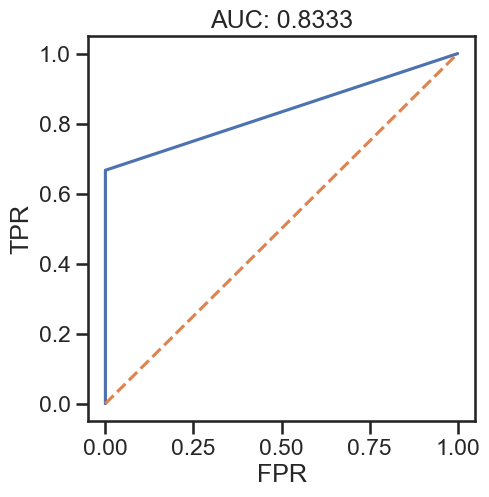

In [24]:
plt.figure(figsize=(5, 5))
plt.plot(fpr_p1, tpr_p1)
plt.plot([0, 1], [0, 1], linestyle="dashed")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.title(f"AUC: {np.round(auc, 4)}")
plt.show()

## cnf matrix

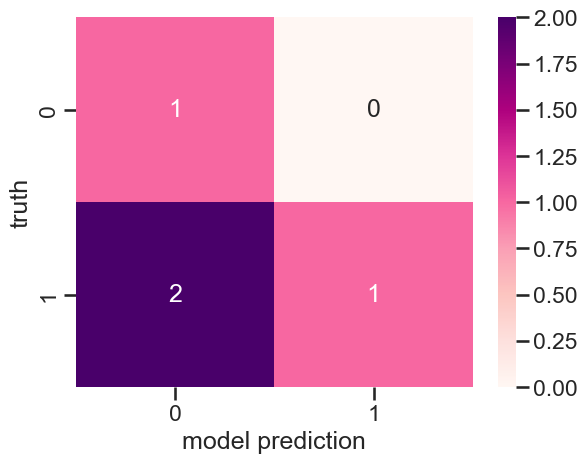

In [41]:
cnf_matrix = metrics.confusion_matrix(y_test, np.rint(predictions))
sns.heatmap(cnf_matrix, annot=True, cmap="RdPu")
plt.xlabel("model prediction")
plt.ylabel("truth")
plt.show()

## cross validation

In [22]:
cv = KFold(n_splits=(Y.shape[0])-1, random_state=1, shuffle=True)

In [23]:
preeclampsia_firstT_model = LogisticRegression(penalty='l1', solver='liblinear')

In [24]:
scores = cross_val_score(preeclampsia_firstT_model, X, Y, scoring='accuracy', cv=cv)
scores

array([1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0.])

In [25]:
p_t1 = np.mean(scores)
p_t1

0.8

# Trimester 2 data prep

In [12]:
second_trimester_data = read_counts.loc[read_counts["trimester"] == "2ndT"]
second_trimester_data.drop("trimester", axis=1, inplace=True)
second_trimester_data = second_trimester_data.T
second_trimester_data["transcript"] = genes["transcript"]
second_trimester_data = second_trimester_data.T
second_trimester_data

,0,1,2,3,4,5,6,7,8,9,...,57727,57728,57729,57730,57731,57732,57733,57734,57735,disease
0,3,9,0,0,0,0,0,0,0,0,...,0,45,3,0,0,0,135,0,0,Preeclampsia
4,19,0,0,0,0,0,0,0,0,0,...,0,41,0,0,0,0,20,0,0,Preeclampsia
10,0,0,0,0,0,0,0,0,0,0,...,0,35,0,0,0,1,112,7,0,Preeclampsia
13,1,0,0,0,0,0,0,0,0,3,...,0,56,0,0,0,21,171,0,0,Preeclampsia
23,9,0,0,0,0,0,0,0,0,2,...,0,31,0,0,0,1,107,0,0,Preeclampsia
24,0,8,0,0,0,0,0,0,0,0,...,0,38,0,0,0,0,98,0,0,Preeclampsia
31,0,0,0,0,3,0,0,0,0,0,...,0,31,0,0,0,13,135,0,0,Preeclampsia
34,1,0,0,0,8,0,0,0,0,0,...,0,38,1,0,0,6,74,2,0,Preeclampsia
42,0,5,0,0,0,0,0,0,0,0,...,0,72,0,0,0,0,110,0,0,Gestational-Diabetes
48,0,0,0,0,2,0,0,0,0,0,...,0,16,0,0,0,10,76,0,0,Gestational-Diabetes


In [13]:
second_trimester_data_copy = second_trimester_data.drop("disease", axis=1)
second_trimester_data_copy = second_trimester_data_copy.drop("transcript", axis=0)
second_trimester_data_copy = second_trimester_data_copy.T
second_trimester_data_copy.to_csv("second_trimester_data.txt", index=False, sep="\t")
second_trimester_data_copy

,0,4,10,13,23,24,31,34,42,48,...,87,88,97,98,104,105,121,122,125,129
0,3,19,0,1,9,0,0,1,0,0,...,0,0,0,0,2,0,0,4,0,0
1,9,0,0,0,0,8,0,0,5,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,3,8,0,2,...,3,0,0,1,0,5,2,0,0,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57731,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
57732,0,0,1,21,1,0,13,6,0,10,...,1,12,8,18,13,25,2,59,28,2
57733,135,20,112,171,107,98,135,74,110,76,...,90,109,97,97,208,173,27,274,155,90
57734,0,0,7,0,0,0,0,2,0,0,...,0,0,0,0,0,0,1,0,7,0


In [14]:
second_trimester_diseases = second_trimester_data["disease"]
second_trimester_diseases = second_trimester_diseases.drop("transcript", axis=0)
second_trimester_diseases.to_csv("second_trimester_diseases.txt", index=False, sep="\t")
second_trimester_diseases

0              Preeclampsia
4              Preeclampsia
10             Preeclampsia
13             Preeclampsia
23             Preeclampsia
24             Preeclampsia
31             Preeclampsia
34             Preeclampsia
42     Gestational-Diabetes
48     Gestational-Diabetes
57     Gestational-Diabetes
58     Gestational-Diabetes
60     Gestational-Diabetes
63     Gestational-Diabetes
65     Gestational-Diabetes
82         Normal-Pregnancy
87         Normal-Pregnancy
88         Normal-Pregnancy
97         Normal-Pregnancy
98         Normal-Pregnancy
104        Normal-Pregnancy
105        Normal-Pregnancy
121        Normal-Pregnancy
122        Normal-Pregnancy
125    Chronic-Hypertension
129    Chronic-Hypertension
Name: disease, dtype: object

# Preeclampsia Trimester 2

## case: preeclampsia control: healthy pregnancy

In [29]:
## lasso regression with a table containing preeclampsia and normal samples during the second trimester
second_trimester_data["preeclampsia"] = np.where(second_trimester_data.disease.str.contains("Preeclampsia"), 1, 0)
preeclampsia_secondT = second_trimester_data[(second_trimester_data.disease == "Normal-Pregnancy")| (second_trimester_data.disease == "Preeclampsia")]
preeclampsia_secondT = preeclampsia_secondT.drop(["disease"], axis=1)
preeclampsia_secondT

,0,1,2,3,4,5,6,7,8,9,...,57727,57728,57729,57730,57731,57732,57733,57734,57735,preeclampsia
0,3,9,0,0,0,0,0,0,0,0,...,0,45,3,0,0,0,135,0,0,1
4,19,0,0,0,0,0,0,0,0,0,...,0,41,0,0,0,0,20,0,0,1
10,0,0,0,0,0,0,0,0,0,0,...,0,35,0,0,0,1,112,7,0,1
13,1,0,0,0,0,0,0,0,0,3,...,0,56,0,0,0,21,171,0,0,1
23,9,0,0,0,0,0,0,0,0,2,...,0,31,0,0,0,1,107,0,0,1
24,0,8,0,0,0,0,0,0,0,0,...,0,38,0,0,0,0,98,0,0,1
31,0,0,0,0,3,0,0,0,0,0,...,0,31,0,0,0,13,135,0,0,1
34,1,0,0,0,8,0,0,0,0,0,...,0,38,1,0,0,6,74,2,0,1
82,0,12,0,0,0,0,0,0,0,0,...,0,8,0,0,0,0,60,0,0,0
87,0,0,0,0,3,0,0,0,0,0,...,0,23,0,0,2,1,90,0,0,0


## differential expression

In [30]:
preeclampsia_dif_exp_secondT = pd.read_csv("preeclamspsia_diffe_secondT.txt", sep=" ")
preeclampsia_dif_exp_secondT = preeclampsia_dif_exp_secondT[preeclampsia_dif_exp_secondT["PValue"] < 0.05]
preeclampsia_dif_exp_secondT

,logFC,logCPM,PValue
1,-3.525107,1.590729,0.018278
11,-2.675605,2.563675,0.042416
15,3.652402,1.796599,0.049773
36,4.555321,9.880109,0.000364
50,4.984551,1.280439,0.042248
...,...,...,...
57633,3.570825,1.580624,0.019455
57642,-3.518724,0.912322,0.042480
57657,-2.692300,1.009396,0.047532
57678,5.302007,1.853951,0.001911


## top differentially expressed genes

In [39]:
preeclampsia_dif_exp_secondT_list = list(preeclampsia_dif_exp_secondT.index)
## print transcripts of all diffe genes
for i in preeclampsia_dif_exp_secondT_list:
    print(second_trimester_data[i]["transcript"])

ENSG00000227232
ENSG00000268903
ENSG00000222623
ENSG00000237973
ENSG00000237491
ENSG00000230368
ENSG00000223823
ENSG00000225905
ENSG00000236684
ENSG00000269737
ENSG00000162585
ENSG00000256761
ENSG00000041988
ENSG00000252404
ENSG00000171603
ENSG00000175206
ENSG00000199347
ENSG00000215695
ENSG00000227684
ENSG00000226664
ENSG00000228823
ENSG00000070831
ENSG00000070886
ENSG00000057757
ENSG00000272432
ENSG00000207302
ENSG00000224129
ENSG00000090273
ENSG00000158246
ENSG00000233975
ENSG00000176261
ENSG00000126067
ENSG00000197982
ENSG00000116983
ENSG00000225333
ENSG00000234694
ENSG00000224863
ENSG00000252018
ENSG00000215883
ENSG00000270209
ENSG00000185839
ENSG00000237227
ENSG00000116783
ENSG00000227556
ENSG00000249237
ENSG00000055732
ENSG00000162645
ENSG00000154451
ENSG00000230735
ENSG00000271949
ENSG00000232393
ENSG00000122483
ENSG00000264963
ENSG00000235501
ENSG00000269998
ENSG00000260879
ENSG00000143126
ENSG00000156097
ENSG00000177272
ENSG00000235527
ENSG00000239984
ENSG00000237993
ENSG0000

In [40]:
preeclampsia_dif_exp_secondT = preeclampsia_dif_exp_secondT.drop(["logFC", "logCPM", "PValue"], axis=1)
preeclampsia_dif_exp_secondT 

""
1
11
15
36
50
...
57633
57642
57657
57678


In [137]:
#preeclampsia_secondT_diffe = preeclampsia_secondT.T
#preeclampsia_secondT_diffe = preeclampsia_secondT_diffe.join(preeclampsia_dif_exp_secondT, how="inner")
#preeclampsia_secondT_diffe = preeclampsia_secondT_diffe.T
#preeclampsia_secondT_diffe["preeclampsia"] = preeclampsia_secondT["preeclampsia"]
preeclampsia_secondT_diffe = preeclampsia_secondT
preeclampsia_secondT_diffe

,0,1,2,3,4,5,6,7,8,9,...,57727,57728,57729,57730,57731,57732,57733,57734,57735,preeclampsia
0,3,9,0,0,0,0,0,0,0,0,...,0,45,3,0,0,0,135,0,0,1
4,19,0,0,0,0,0,0,0,0,0,...,0,41,0,0,0,0,20,0,0,1
10,0,0,0,0,0,0,0,0,0,0,...,0,35,0,0,0,1,112,7,0,1
13,1,0,0,0,0,0,0,0,0,3,...,0,56,0,0,0,21,171,0,0,1
23,9,0,0,0,0,0,0,0,0,2,...,0,31,0,0,0,1,107,0,0,1
24,0,8,0,0,0,0,0,0,0,0,...,0,38,0,0,0,0,98,0,0,1
31,0,0,0,0,3,0,0,0,0,0,...,0,31,0,0,0,13,135,0,0,1
34,1,0,0,0,8,0,0,0,0,0,...,0,38,1,0,0,6,74,2,0,1
82,0,12,0,0,0,0,0,0,0,0,...,0,8,0,0,0,0,60,0,0,0
87,0,0,0,0,3,0,0,0,0,0,...,0,23,0,0,2,1,90,0,0,0


## binary lasso reg

In [145]:
X = preeclampsia_secondT_diffe.loc[:, preeclampsia_secondT_diffe.columns != "preeclampsia"] # use all columns that aren't the outcome for input
Y = preeclampsia_secondT_diffe["preeclampsia"] # use the binary outcome column for Y 

In [146]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

In [147]:
preeclampsia_secondT_model = LogisticRegression(penalty='l1', solver='liblinear')
preeclampsia_secondT_model.fit(x_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [148]:
predictions = preeclampsia_secondT_model.predict(x_test) # we then test it on our held out data

In [149]:
accuracy_score(y_test, predictions)

0.5

In [150]:
mean_squared_error(y_test, predictions)

0.5

## top lasso genes

In [38]:
preeclampsia_secondT_model.coef_

array([[0., 0., 0., ..., 0., 0., 0.]])

In [49]:
print(list(zip(preeclampsia_secondT_model.coef_, list(x_train)))) # these are the coefficients with each of the input variable names 

[(array([0., 0., 0., ..., 0., 0., 0.]), 0)]


In [50]:
top_lasso_genes = []
for coef, gene in zip(list(preeclampsia_secondT_model.coef_)[0], list(x_train)):
    if (coef != 0):
        #print(second_trimester_data[gene]["transcript"])
        top_lasso_genes.append(second_trimester_data[gene]["transcript"])
        preeclampsia_secondT_top_lasso_genes = pd.DataFrame(top_lasso_genes, columns = ['gene'])
        
preeclampsia_secondT_top_lasso_genes.to_csv("preeclampsia_secondT_top_lasso_genes.txt", index=False, sep="\t")
preeclampsia_secondT_top_lasso_genes      

,gene
0,ENSG00000163220
1,ENSG00000201321
2,ENSG00000115993
3,ENSG00000163359
4,ENSG00000199994
5,ENSG00000201822
6,ENSG00000163736
7,ENSG00000156508
8,ENSG00000075624
9,ENSG00000252316


In [51]:
## genes common between differential expression and top lasso
diffe = set(preeclampsia_dif_exp_secondT_list)
tlg = set(preeclampsia_secondT_top_lasso_genes["gene"])
common_genes = diffe.intersection(tlg)
print(common_genes)

NameError: name 'preeclampsia_dif_exp_secondT_list' is not defined

## cnf matrix

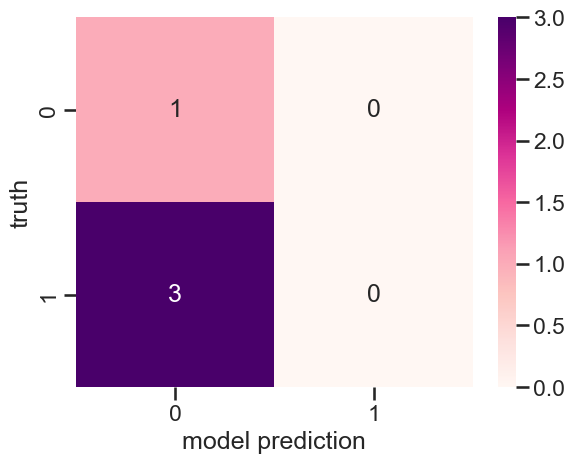

In [377]:
cnf_matrix = metrics.confusion_matrix(y_test, np.rint(predictions))
sns.heatmap(cnf_matrix, annot=True, cmap="RdPu")
plt.xlabel("model prediction")
plt.ylabel("truth")
plt.show()

## AUC/ROC curve

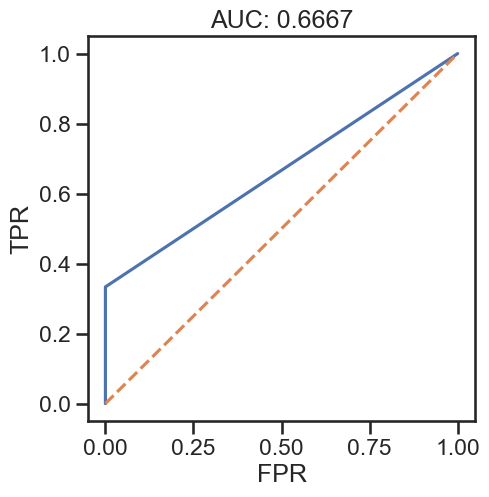

In [151]:
fpr_p2, tpr_p2, _ = metrics.roc_curve(y_test, np.rint(predictions))
auc = metrics.roc_auc_score(y_test, np.rint(predictions))
p_t2_auc = auc
plt.figure(figsize=(5, 5))
plt.plot(fpr_p2, tpr_p2)
plt.plot([0, 1], [0, 1], linestyle="dashed")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.title(f"AUC: {np.round(auc, 4)}")
plt.show()

## cross validation

In [131]:
cv = KFold(n_splits=(Y.shape[0])-1, random_state=1, shuffle=True)

In [132]:
preeclampsia_secondT_model = LogisticRegression(penalty='l1', solver='liblinear')

In [133]:
scores = cross_val_score(preeclampsia_secondT_model, X, Y, scoring='accuracy', cv=cv)
scores

array([1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.])

In [134]:
p_t2 = np.mean(scores)
p_t2

0.5

# Trimester 3 data prep

In [15]:
## case: preeclampsia control: healthy pregnancythird_trimester_data = read_counts.loc[read_counts["trimester"] == "3rdT"]
third_trimester_data.drop("trimester", axis=1, inplace=True)
third_trimester_data = third_trimester_data.T
third_trimester_data["transcript"] = genes["transcript"]
third_trimester_data = third_trimester_data.T
third_trimester_data

,0,1,2,3,4,5,6,7,8,9,...,57727,57728,57729,57730,57731,57732,57733,57734,57735,disease
11,0,0,0,0,0,0,0,3,0,0,...,0,5,0,0,0,3,46,1,0,Preeclampsia
12,0,0,1,0,5,0,0,2,0,2,...,0,35,0,0,1,9,127,0,0,Preeclampsia
14,0,4,0,0,0,0,0,0,0,0,...,0,42,0,0,0,0,213,3,0,Preeclampsia
15,1,0,0,0,2,0,0,0,0,2,...,2,59,0,0,0,11,123,0,0,Preeclampsia
29,0,1,0,0,0,5,1,2,0,0,...,4,83,0,0,4,13,74,10,0,Preeclampsia
33,0,0,0,0,0,0,0,0,0,0,...,0,51,0,0,0,6,175,0,0,Preeclampsia
35,34,2,0,0,0,0,0,0,0,4,...,0,11,0,0,0,1,109,1,0,Preeclampsia
36,0,0,0,0,0,0,0,0,0,2,...,8,47,0,0,0,1,122,0,0,Preeclampsia
40,1,0,0,0,0,0,0,0,0,0,...,0,20,0,0,0,3,71,0,0,Gestational-Diabetes
46,2,8,0,0,0,0,0,0,0,0,...,0,29,0,0,0,0,116,0,0,Gestational-Diabetes


In [16]:
third_trimester_data_copy = third_trimester_data.drop("disease", axis=1)
third_trimester_data_copy = third_trimester_data_copy.drop("transcript", axis=0)
third_trimester_data_copy = third_trimester_data_copy.T
third_trimester_data_copy.to_csv("third_trimester_data.txt", index=False, sep="\t")
third_trimester_data_copy

,11,12,14,15,29,33,35,36,40,46,...,86,96,101,102,106,107,112,115,127,131
0,0,0,0,1,0,0,34,0,1,2,...,6,0,0,20,0,0,1,0,0,0
1,0,0,4,0,1,0,2,0,0,8,...,0,2,2,2,0,1,0,0,0,2
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,5,0,2,0,0,0,0,0,0,...,0,0,0,0,10,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57731,0,1,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
57732,3,9,0,11,13,6,1,1,3,0,...,0,3,30,5,26,26,5,5,3,5
57733,46,127,213,123,74,175,109,122,71,116,...,40,102,570,96,70,422,205,116,146,139
57734,1,0,3,0,10,0,1,0,0,0,...,0,1,0,0,2,0,8,1,0,3


In [17]:
third_trimester_diseases = third_trimester_data["disease"]
third_trimester_diseases = third_trimester_diseases.drop("transcript", axis=0)
third_trimester_diseases.to_csv("third_trimester_diseases.txt", index=False, sep="\t")
third_trimester_diseases

11             Preeclampsia
12             Preeclampsia
14             Preeclampsia
15             Preeclampsia
29             Preeclampsia
33             Preeclampsia
35             Preeclampsia
36             Preeclampsia
40     Gestational-Diabetes
46     Gestational-Diabetes
55     Gestational-Diabetes
68     Gestational-Diabetes
69     Gestational-Diabetes
72     Gestational-Diabetes
81         Normal-Pregnancy
86         Normal-Pregnancy
96         Normal-Pregnancy
101        Normal-Pregnancy
102        Normal-Pregnancy
106        Normal-Pregnancy
107        Normal-Pregnancy
112        Normal-Pregnancy
115        Normal-Pregnancy
127    Chronic-Hypertension
131    Chronic-Hypertension
Name: disease, dtype: object

# Preeclampsia Trimester 3

## case: preeclampsia control: healthy pregnancy

In [152]:
## case: preeclampsia control: healthy pregnancythird_trimester_data["preeclampsia"] = np.where(third_trimester_data.disease.str.contains("Preeclampsia"), 1, 0)
preeclampsia_thirdT = third_trimester_data.drop(["disease"], axis=1)
preeclampsia_thirdT = third_trimester_data[(third_trimester_data.disease == "Normal-Pregnancy")| (third_trimester_data.disease == "Preeclampsia")]
preeclampsia_thirdT = preeclampsia_thirdT.drop(["disease"], axis=1)
preeclampsia_thirdT

,0,1,2,3,4,5,6,7,8,9,...,57730,57731,57732,57733,57734,57735,preeclampsia,gestational_diabetes,chronic_hypertension,normal_pregnancy
11,0,0,0,0,0,0,0,3,0,0,...,0,0,3,46,1,0,1,0,0,0
12,0,0,1,0,5,0,0,2,0,2,...,0,1,9,127,0,0,1,0,0,0
14,0,4,0,0,0,0,0,0,0,0,...,0,0,0,213,3,0,1,0,0,0
15,1,0,0,0,2,0,0,0,0,2,...,0,0,11,123,0,0,1,0,0,0
29,0,1,0,0,0,5,1,2,0,0,...,0,4,13,74,10,0,1,0,0,0
33,0,0,0,0,0,0,0,0,0,0,...,0,0,6,175,0,0,1,0,0,0
35,34,2,0,0,0,0,0,0,0,4,...,0,0,1,109,1,0,1,0,0,0
36,0,0,0,0,0,0,0,0,0,2,...,0,0,1,122,0,0,1,0,0,0
81,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
86,6,0,0,0,0,0,0,0,0,0,...,0,0,0,40,0,0,0,0,0,1


In [44]:
preeclampsia_dif_exp_thirdT = pd.read_csv("preeclamspsia_diffe_thirdT.txt", sep=" ")
preeclampsia_dif_exp_thirdT = preeclampsia_dif_exp_thirdT[preeclampsia_dif_exp_thirdT["PValue"] < 0.05]
preeclampsia_dif_exp_thirdT

,logFC,logCPM,PValue
35,3.785983,7.587090,0.000810
36,3.469072,8.204059,0.000178
55,-4.130930,0.988338,0.023017
56,-2.269121,1.401286,0.046918
58,-2.714558,1.418684,0.031237
...,...,...,...
57681,-3.617769,1.315715,0.008822
57705,-4.415154,1.432204,0.000135
57710,-3.418465,0.761950,0.013641
57726,-1.296859,3.469206,0.038172


## top diffe genes

In [135]:
preeclampsia_dif_exp_thirdT_list = list(preeclampsia_dif_exp_thirdT.index)
## print transcripts of all diffe genes
for i in preeclampsia_dif_exp_thirdT_list:
    print(third_trimester_data[i]["transcript"])

ENSG00000225630
ENSG00000237973
ENSG00000225880
ENSG00000228794
ENSG00000234711
ENSG00000268179
ENSG00000187642
ENSG00000162571
ENSG00000186827
ENSG00000160087
ENSG00000162572
ENSG00000131584
ENSG00000107404
ENSG00000197530
ENSG00000227775
ENSG00000233542
ENSG00000272161
ENSG00000269896
ENSG00000272449
ENSG00000238164
ENSG00000157873
ENSG00000228037
ENSG00000233234
ENSG00000226286
ENSG00000272088
ENSG00000227589
ENSG00000264341
ENSG00000173673
ENSG00000265392
ENSG00000253022
ENSG00000173662
ENSG00000270330
ENSG00000238290
ENSG00000232848
ENSG00000200975
ENSG00000232663
ENSG00000265141
ENSG00000142583
ENSG00000252404
ENSG00000171603
ENSG00000251503
ENSG00000272078
ENSG00000225158
ENSG00000009724
ENSG00000204624
ENSG00000235643
ENSG00000224904
ENSG00000116685
ENSG00000263676
ENSG00000222952
ENSG00000171729
ENSG00000233485
ENSG00000224459
ENSG00000185519
ENSG00000204377
ENSG00000271732
ENSG00000207513
ENSG00000268991
ENSG00000238142
ENSG00000226526
ENSG00000227751
ENSG00000117154
ENSG0000

ENSG00000080644
ENSG00000259555
ENSG00000235711
ENSG00000259642
ENSG00000086666
ENSG00000259495
ENSG00000172379
ENSG00000258010
ENSG00000259175
ENSG00000271725
ENSG00000259372
ENSG00000259328
ENSG00000259462
ENSG00000250988
ENSG00000259986
ENSG00000140600
ENSG00000259244
ENSG00000251891
ENSG00000183655
ENSG00000252964
ENSG00000200206
ENSG00000140543
ENSG00000221630
ENSG00000140511
ENSG00000259218
ENSG00000166819
ENSG00000166821
ENSG00000259441
ENSG00000259262
ENSG00000258542
ENSG00000258551
ENSG00000258765
ENSG00000259064
ENSG00000258627
ENSG00000258831
ENSG00000259702
ENSG00000259542
ENSG00000258483
ENSG00000259507
ENSG00000261054
ENSG00000261616
ENSG00000259228
ENSG00000268730
ENSG00000259604
ENSG00000140479
ENSG00000259764
ENSG00000252614
ENSG00000232459
ENSG00000257109
ENSG00000234769
ENSG00000260803
ENSG00000103152
ENSG00000206178
ENSG00000206172
ENSG00000207243
ENSG00000090565
ENSG00000103269
ENSG00000127585
ENSG00000162004
ENSG00000103253
ENSG00000162006
ENSG00000207579
ENSG0000

In [136]:
preeclampsia_dif_exp_thirdT = preeclampsia_dif_exp_thirdT.drop(["logFC", "logCPM", "PValue"], axis=1)
preeclampsia_dif_exp_thirdT 

""
35
36
55
56
58
...
57681
57705
57710
57726


In [153]:
#preeclampsia_thirdT_diffe = preeclampsia_thirdT.T
#preeclampsia_thirdT_diffe = preeclampsia_thirdT_diffe.join(preeclampsia_dif_exp_thirdT, how="inner")
#preeclampsia_thirdT_diffe = preeclampsia_thirdT_diffe.T
#preeclampsia_thirdT_diffe["preeclampsia"] = preeclampsia_thirdT["preeclampsia"]
preeclampsia_thirdT_diffe = preeclampsia_thirdT
preeclampsia_thirdT_diffe

,0,1,2,3,4,5,6,7,8,9,...,57730,57731,57732,57733,57734,57735,preeclampsia,gestational_diabetes,chronic_hypertension,normal_pregnancy
11,0,0,0,0,0,0,0,3,0,0,...,0,0,3,46,1,0,1,0,0,0
12,0,0,1,0,5,0,0,2,0,2,...,0,1,9,127,0,0,1,0,0,0
14,0,4,0,0,0,0,0,0,0,0,...,0,0,0,213,3,0,1,0,0,0
15,1,0,0,0,2,0,0,0,0,2,...,0,0,11,123,0,0,1,0,0,0
29,0,1,0,0,0,5,1,2,0,0,...,0,4,13,74,10,0,1,0,0,0
33,0,0,0,0,0,0,0,0,0,0,...,0,0,6,175,0,0,1,0,0,0
35,34,2,0,0,0,0,0,0,0,4,...,0,0,1,109,1,0,1,0,0,0
36,0,0,0,0,0,0,0,0,0,2,...,0,0,1,122,0,0,1,0,0,0
81,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
86,6,0,0,0,0,0,0,0,0,0,...,0,0,0,40,0,0,0,0,0,1


## preeclampsia binary lasso reg

In [154]:
X = preeclampsia_thirdT_diffe.loc[:, preeclampsia_thirdT_diffe.columns != "preeclampsia"] # use all columns that aren't the outcome for input
Y = preeclampsia_thirdT_diffe["preeclampsia"] # use the binary outcome column for Y 

In [155]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

In [156]:
preeclampsia_thirdT_model = LogisticRegression(penalty='l1', solver='liblinear')
preeclampsia_thirdT_model.fit(x_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [157]:
predictions = preeclampsia_thirdT_model.predict(x_test) # we then test it on our held out data

In [158]:
accuracy_score(y_test, predictions)

0.5

In [159]:
mean_squared_error(y_test, predictions)

0.5

In [52]:
preeclampsia_thirdT_model.coef_

array([[0., 0., 0., ..., 0., 0., 0.]])

## top lasso genes

In [67]:
top_lasso_genes = []
for coef, gene in zip(list(preeclampsia_thirdT_model.coef_)[0], list(x_train)):
    if (coef != 0):
        #print(third_trimester_data[gene]["transcript"])
        top_lasso_genes.append(third_trimester_data[gene]["transcript"])
        preeclampsia_thirdT_top_lasso_genes = pd.DataFrame(top_lasso_genes, columns = ['gene'])
        
preeclampsia_thirdT_top_lasso_genes.to_csv("preeclampsia_thirdT_top_lasso_genes.txt", index=False, sep="\t")
preeclampsia_thirdT_top_lasso_genes

,gene
0,ENSG00000225630
1,ENSG00000122406
2,ENSG00000183508
3,ENSG00000163220
4,ENSG00000143546
...,...
62,ENSG00000167526
63,ENSG00000184009
64,ENSG00000087086
65,ENSG00000142541


In [88]:
## genes common between differential expression and top lasso
diffe = set(preeclampsia_dif_exp_thirdT_list)
tlg = set(preeclampsia_thirdT_top_lasso_genes["gene"])
common_genes = diffe.intersection(tlg)
print(common_genes)

NameError: name 'preeclampsia_dif_exp_thirdT_list' is not defined

## cnf matrix

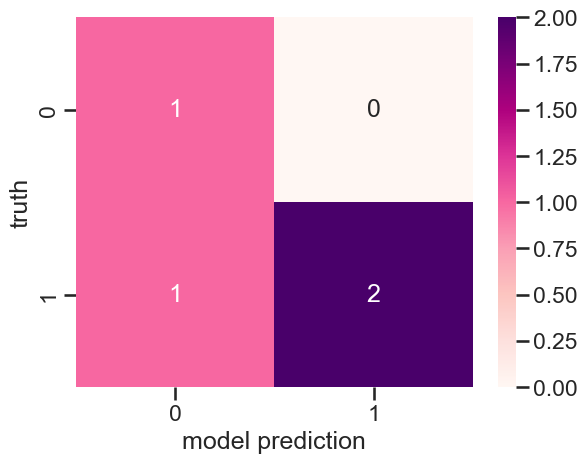

In [392]:
cnf_matrix = metrics.confusion_matrix(y_test, np.rint(predictions))
sns.heatmap(cnf_matrix, annot=True, cmap="RdPu")
plt.xlabel("model prediction")
plt.ylabel("truth")
plt.show()

## AUC/ROC curve

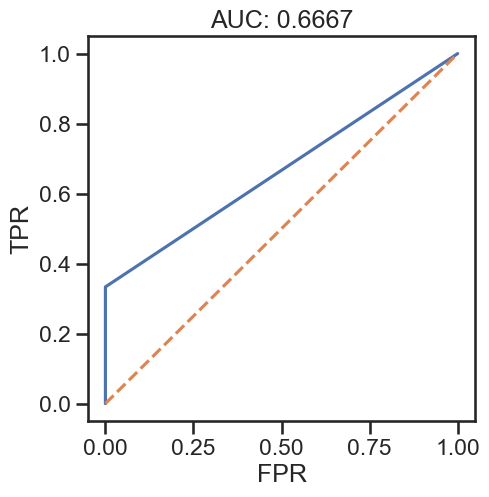

In [161]:
fpr_p3, tpr_p3, _ = metrics.roc_curve(y_test, np.rint(predictions))
auc = metrics.roc_auc_score(y_test, np.rint(predictions))
p_t3_auc = auc
plt.figure(figsize=(5, 5))
plt.plot(fpr_p3, tpr_p3)
plt.plot([0, 1], [0, 1], linestyle="dashed")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.title(f"AUC: {np.round(auc, 4)}")
plt.show()

## cross validation

In [121]:
cv = KFold(n_splits=(Y.shape[0])-1, random_state=1, shuffle=True)

In [122]:
preeclampsia_thirdT_model = LogisticRegression(penalty='l1', solver='liblinear')

In [123]:
scores = cross_val_score(preeclampsia_thirdT_model, X, Y, scoring='accuracy', cv=cv)
scores

array([0.5, 1. , 1. , 0. , 1. , 0. , 0. , 1. , 0. , 1. , 1. , 0. , 0. ,
       1. , 0. , 1. ])

In [124]:
p_t3 = np.mean(scores)
p_t3

0.53125

# diffe venn diagram for each trimester

In [75]:
t1 = len(list(preeclampsia_dif_exp_firstT_list))
t2 = len(list(preeclampsia_dif_exp_secondT_list))
t3 = len(list(preeclampsia_dif_exp_thirdT_list))

NameError: name 'preeclampsia_dif_exp_secondT_list' is not defined

In [151]:
preeclampsia_dif_exp_firstT_list = set(preeclampsia_dif_exp_firstT_list)
preeclampsia_dif_exp_secondT_list = set(preeclampsia_dif_exp_secondT_list)
preeclampsia_dif_exp_thirdT_list = set(preeclampsia_dif_exp_thirdT_list)
t1_t2 = len(list(preeclampsia_dif_exp_firstT_list.intersection(preeclampsia_dif_exp_secondT_list)))
t1_t3 = len(list(preeclampsia_dif_exp_firstT_list.intersection(preeclampsia_dif_exp_thirdT_list)))
t2_t3 = len(list(preeclampsia_dif_exp_secondT_list.intersection(preeclampsia_dif_exp_thirdT_list)))
t1_t2_t3 = len(list(preeclampsia_dif_exp_firstT_list.intersection(preeclampsia_dif_exp_secondT_list.intersection(preeclampsia_dif_exp_thirdT_list))))

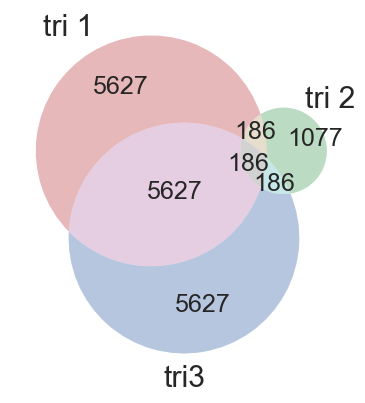

In [152]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
venn3(subsets = (t1, t2, t1_t2, t3, t1_t3, t2_t3, t1_t2_t3), set_labels = ('tri 1', 'tri 2', 'tri3'))
plt.show()

# Trimester 1 GD

## case: gestational diabetes control: healthy pregnancy

In [162]:
first_trimester_data["gestational_diabetes"] = np.where(first_trimester_data.disease.str.contains("Gestational-Diabetes"), 1, 0)
gestational_diabetes_firstT = first_trimester_data.drop(["disease"], axis=1)
gestational_diabetes_firstT = first_trimester_data[(first_trimester_data.disease == "Normal-Pregnancy")| (first_trimester_data.disease == "Gestational-Diabetes")]
gestational_diabetes_firstT = gestational_diabetes_firstT.drop(["disease", "preeclampsia"], axis=1)
gestational_diabetes_firstT

,0,1,2,3,4,5,6,7,8,9,...,57729,57730,57731,57732,57733,57734,57735,gestational_diabetes,chronic_hypertension,normal_pregnancy
43,0,5,0,0,0,0,0,0,0,1,...,0,0,0,0,65,0,0,1,0,0
44,11,0,0,0,0,0,0,0,0,0,...,0,0,0,4,95,1,0,1,0,0
49,0,1,0,0,2,0,0,1,0,2,...,4,0,2,2,82,0,0,1,0,0
56,0,0,0,0,6,0,0,0,0,0,...,0,0,1,8,131,0,0,1,0,0
66,13,0,0,0,4,0,0,0,0,1,...,0,0,0,19,105,3,0,1,0,0
70,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,36,0,0,1,0,0
71,8,3,0,0,0,0,0,0,0,0,...,0,0,0,0,70,0,0,1,0,0
83,0,0,0,0,0,0,0,0,0,1,...,0,0,0,28,371,8,0,0,0,1
89,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,146,0,0,0,0,1
92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,44,0,0,0,0,1


## binary lasso reg

In [169]:
X = gestational_diabetes_firstT.loc[:, gestational_diabetes_firstT.columns != "gestational_diabetes"] # use all columns that aren't the outcome for input
Y = gestational_diabetes_firstT["gestational_diabetes"] # use the binary outcome column for Y 

In [170]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

In [171]:
gestational_diabetes_firstT_model = LogisticRegression(penalty='l1', solver='liblinear')
gestational_diabetes_firstT_model.fit(x_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [172]:
predictions = gestational_diabetes_firstT_model.predict(x_test) # we then test it on our held out data

In [173]:
accuracy_score(y_test, predictions)

0.3333333333333333

In [60]:
mean_squared_error(y_test, predictions)

0.6666666666666666

In [61]:
gestational_diabetes_firstT_model.coef_

array([[0., 0., 0., ..., 0., 0., 0.]])

## top lasso genes

In [111]:
top_lasso_genes = []
for coef, gene in zip(list(gestational_diabetes_firstT_model.coef_)[0], list(x_train)):
    if (coef != 0):
        #print(third_trimester_data[gene]["transcript"])
        top_lasso_genes.append(first_trimester_data[gene]["transcript"])
        gestational_diabetes_firstT_top_lasso_genes = pd.DataFrame(top_lasso_genes, columns = ['gene'])
        
gestational_diabetes_firstT_top_lasso_genes.to_csv("gestational_diabetes_firstT_top_lasso_genes.txt", index=False, sep="\t")
gestational_diabetes_firstT_top_lasso_genes

,gene
0,ENSG00000237973
1,ENSG00000142669
2,ENSG00000142937
3,ENSG00000117289
4,ENSG00000163220
...,...
75,ENSG00000105193
76,ENSG00000087086
77,ENSG00000142541
78,ENSG00000156265


## plots

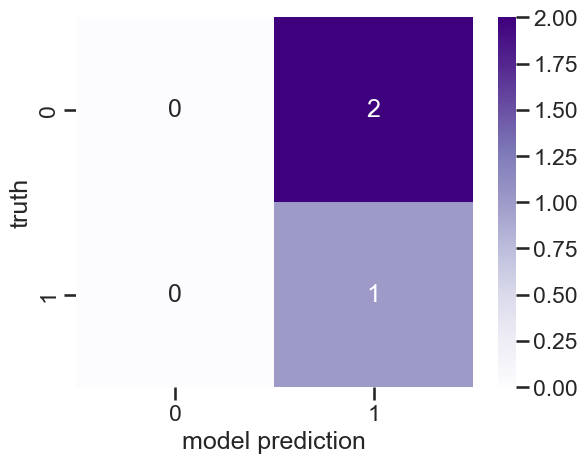

In [401]:
cnf_matrix = metrics.confusion_matrix(y_test, np.rint(predictions))
sns.heatmap(cnf_matrix, annot=True, cmap="Purples")
plt.xlabel("model prediction")
plt.ylabel("truth")
plt.show()

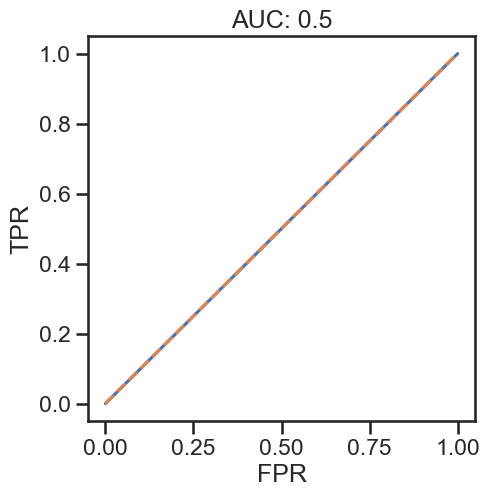

In [174]:
fpr_gd1, tpr_gd1, _ = metrics.roc_curve(y_test, np.rint(predictions))
auc = metrics.roc_auc_score(y_test, np.rint(predictions))
gd_t1_auc = auc
plt.figure(figsize=(5, 5))
plt.plot(fpr_gd1, tpr_gd1)
plt.plot([0, 1], [0, 1], linestyle="dashed")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.title(f"AUC: {np.round(auc, 4)}")
plt.show()

## cross validation

In [165]:
cv = KFold(n_splits=(Y.shape[0])-1, random_state=1, shuffle=True)

In [166]:
gestational_diabetes_firstT_model = LogisticRegression(penalty='l1', solver='liblinear')

In [167]:
scores = cross_val_score(gestational_diabetes_firstT_model, X, Y, scoring='accuracy', cv=cv)
scores

array([0.5, 0. , 1. , 1. , 1. , 0. , 1. , 1. , 1. , 1. , 0. , 0. , 1. ,
       1. ])

In [168]:
gd_t1 = np.mean(scores)
gd_t1

0.6785714285714286

# Trimester 2 GD

## case: gestational diabetes control: healthy pregnancy

In [177]:
second_trimester_data["gestational_diabetes"] = np.where(second_trimester_data.disease.str.contains("Gestational-Diabetes"), 1, 0)
gestational_diabetes_secondT = second_trimester_data.drop(["disease"], axis=1)
gestational_diabetes_secondT = second_trimester_data[(second_trimester_data.disease == "Normal-Pregnancy")| (second_trimester_data.disease == "Gestational-Diabetes")]
gestational_diabetes_secondT = gestational_diabetes_secondT.drop(["disease"], axis=1)
gestational_diabetes_secondT

,0,1,2,3,4,5,6,7,8,9,...,57727,57728,57729,57730,57731,57732,57733,57734,57735,gestational_diabetes
42,0,5,0,0,0,0,0,0,0,0,...,0,72,0,0,0,0,110,0,0,1
48,0,0,0,0,2,0,0,0,0,0,...,0,16,0,0,0,10,76,0,0,1
57,2,0,0,0,15,0,0,0,0,1,...,0,39,0,0,0,8,146,1,0,1
58,0,0,0,0,9,1,0,0,0,0,...,0,14,0,0,0,4,49,3,0,1
60,0,0,0,0,0,0,0,0,0,0,...,0,58,0,0,0,0,1,0,0,1
63,0,0,0,0,0,0,0,0,0,0,...,0,61,0,0,0,0,102,0,0,1
65,0,0,0,0,0,0,0,0,0,1,...,0,17,0,0,0,1,157,0,0,1
82,0,12,0,0,0,0,0,0,0,0,...,0,8,0,0,0,0,60,0,0,0
87,0,0,0,0,3,0,0,0,0,0,...,0,23,0,0,2,1,90,0,0,0
88,0,0,0,0,0,0,0,0,0,0,...,1,28,0,0,0,12,109,0,0,0


## binary lasso reg

In [178]:
X = gestational_diabetes_secondT.loc[:, gestational_diabetes_secondT.columns != "gestational_diabetes"] # use all columns that aren't the outcome for input
Y = gestational_diabetes_secondT["gestational_diabetes"] # use the binary outcome column for Y 

In [179]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

In [180]:
gestational_diabetes_secondT_model = LogisticRegression(penalty='l1', solver='liblinear')
gestational_diabetes_secondT_model.fit(x_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [181]:
predictions = gestational_diabetes_secondT_model.predict(x_test) # we then test it on our held out data

In [182]:
accuracy_score(y_test, predictions)

0.75

In [69]:
mean_squared_error(y_test, predictions)

0.25

In [70]:
gestational_diabetes_secondT_model.coef_

array([[0., 0., 0., ..., 0., 0., 0.]])

## top lasso genes

In [96]:
top_lasso_genes = []
for coef, gene in zip(list(gestational_diabetes_secondT_model.coef_)[0], list(x_train)):
    if (coef != 0):
        #print(third_trimester_data[gene]["transcript"])
        top_lasso_genes.append(second_trimester_data[gene]["transcript"])
        gestational_diabetes_secondT_top_lasso_genes = pd.DataFrame(top_lasso_genes, columns = ['gene'])
        
gestational_diabetes_secondT_top_lasso_genes.to_csv("gestational_diabetes_secondT_top_lasso_genes.txt", index=False, sep="\t")
gestational_diabetes_secondT_top_lasso_genes

,gene
0,ENSG00000163220
1,ENSG00000143546
2,ENSG00000115993
3,ENSG00000163359
4,ENSG00000269028
5,ENSG00000199994
6,ENSG00000201822
7,ENSG00000163736
8,ENSG00000156508
9,ENSG00000075624


## plots

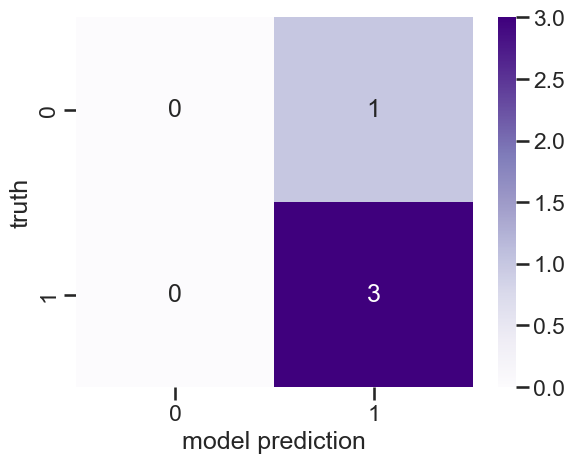

In [409]:
cnf_matrix = metrics.confusion_matrix(y_test, np.rint(predictions))
sns.heatmap(cnf_matrix, annot=True, cmap="Purples")
plt.xlabel("model prediction")
plt.ylabel("truth")
plt.show()

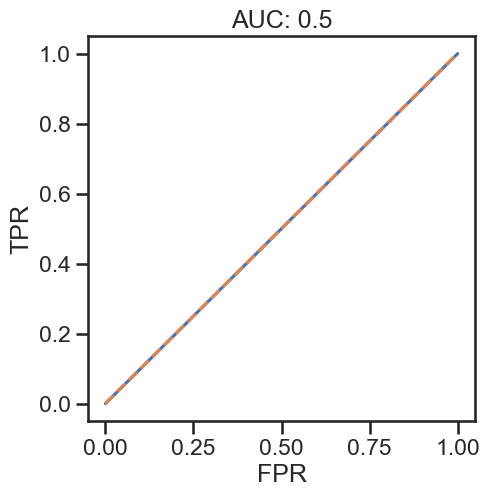

In [183]:
fpr_gd2, tpr_gd2, _ = metrics.roc_curve(y_test, np.rint(predictions))
auc = metrics.roc_auc_score(y_test, np.rint(predictions))
gd_t2_auc = auc
plt.figure(figsize=(5, 5))
plt.plot(fpr_gd2, tpr_gd2)
plt.plot([0, 1], [0, 1], linestyle="dashed")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.title(f"AUC: {np.round(auc, 4)}")
plt.show()

## cross validation

In [177]:
cv = KFold(n_splits=(Y.shape[0])-1, random_state=1, shuffle=True)

In [178]:
gestational_diabetes_secondT_model = LogisticRegression(penalty='l1', solver='liblinear')

In [179]:
scores = cross_val_score(gestational_diabetes_secondT_model, X, Y, scoring='accuracy', cv=cv)
scores

array([0.5, 1. , 0. , 0. , 1. , 1. , 1. , 0. , 0. , 1. , 0. , 0. , 0. ,
       1. , 0. ])

In [180]:
gd_t2 = np.mean(scores)
gd_t2

0.43333333333333335

# Trimester 3 GD

## case: gestational diabetes control: healthy pregnancy

In [184]:
## case: gestational diabetes control: healthy pregnancythird_trimester_data["gestational_diabetes"] = np.where(third_trimester_data.disease.str.contains("Gestational-Diabetes"), 1, 0)
gestational_diabetes_thirdT = third_trimester_data.drop(["disease"], axis=1)
gestational_diabetes_thirdT = third_trimester_data[(third_trimester_data.disease == "Normal-Pregnancy")| (third_trimester_data.disease == "Gestational-Diabetes")]
gestational_diabetes_thirdT = gestational_diabetes_thirdT.drop(["disease", "preeclampsia"], axis=1)
gestational_diabetes_thirdT

,0,1,2,3,4,5,6,7,8,9,...,57729,57730,57731,57732,57733,57734,57735,gestational_diabetes,chronic_hypertension,normal_pregnancy
40,1,0,0,0,0,0,0,0,0,0,...,0,0,0,3,71,0,0,1,0,0
46,2,8,0,0,0,0,0,0,0,0,...,0,0,0,0,116,0,0,1,0,0
55,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,37,0,0,1,0,0
68,43,0,0,0,9,0,0,0,0,1,...,0,0,0,5,77,0,0,1,0,0
69,4,1,0,0,4,0,0,0,0,1,...,0,0,0,0,50,5,0,1,0,0
72,0,5,0,0,1,0,0,0,0,0,...,0,0,0,1,69,0,0,1,0,0
81,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
86,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,40,0,0,0,0,1
96,0,2,0,0,0,0,0,0,0,0,...,0,0,0,3,102,1,0,0,0,1
101,0,2,0,0,0,0,0,0,0,2,...,0,0,0,30,570,0,0,0,0,1


## binary lasso reg

In [185]:
X = gestational_diabetes_thirdT.loc[:, gestational_diabetes_thirdT.columns != "gestational_diabetes"] # use all columns that aren't the outcome for input
Y = gestational_diabetes_thirdT["gestational_diabetes"] # use the binary outcome column for Y 

In [186]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2, random_state=42)

In [187]:
gestational_diabetes_thirdT_model = LogisticRegression(penalty='l1', solver='liblinear')
gestational_diabetes_thirdT_model.fit(x_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [188]:
predictions = gestational_diabetes_thirdT_model.predict(x_test) # we then test it on our held out data

In [189]:
accuracy_score(y_test, predictions)

0.3333333333333333

In [78]:
mean_squared_error(y_test, predictions)

0.6666666666666666

In [417]:
gestational_diabetes_thirdT_model.coef_

array([[0., 0., 0., ..., 0., 0., 0.]])

## top lasso genes

In [246]:
top_lasso_genes = []
for coef, gene in zip(list(gestational_diabetes_thirdT_model.coef_)[0], list(x_train)):
    if (coef != 0):
        #print(third_trimester_data[gene]["transcript"])
        top_lasso_genes.append(third_trimester_data[gene]["transcript"])
        gestational_diabetes_thirdT_top_lasso_genes = pd.DataFrame(top_lasso_genes, columns = ['gene'])
        
gestational_diabetes_thirdT_top_lasso_genes.to_csv("gestational_diabetes_thirdT_top_lasso_genes.txt", index=False, sep="\t")
gestational_diabetes_thirdT_top_lasso_genes

,gene
0,ENSG00000225630
1,ENSG00000163220
2,ENSG00000115993
3,ENSG00000163359
4,ENSG00000199994
5,ENSG00000201822
6,ENSG00000163736
7,ENSG00000061455
8,ENSG00000204628
9,ENSG00000124491


## plots

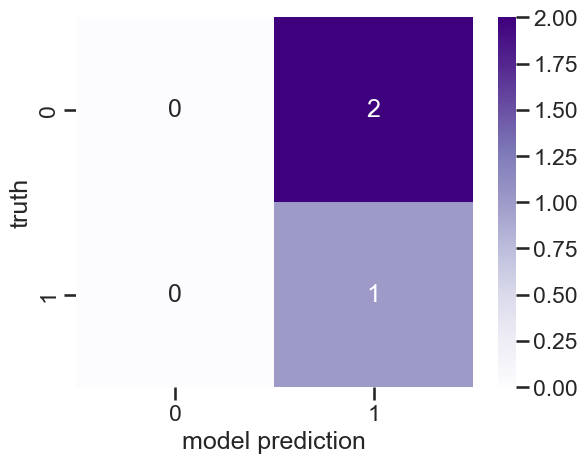

In [418]:
cnf_matrix = metrics.confusion_matrix(y_test, np.rint(predictions))
sns.heatmap(cnf_matrix, annot=True, cmap="Purples")
plt.xlabel("model prediction")
plt.ylabel("truth")
plt.show()

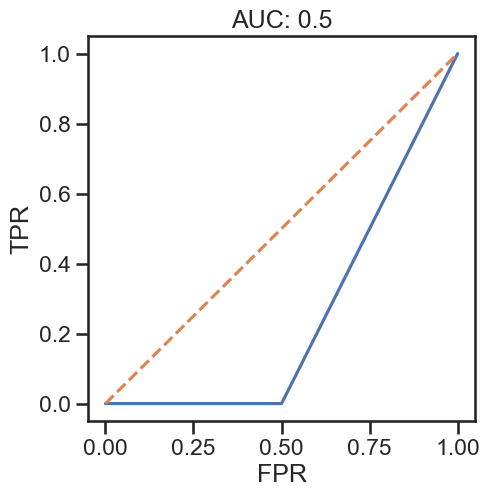

In [190]:
fpr_gd3, tpr_gd3, _ = metrics.roc_curve(y_test, np.rint(predictions))
auc = metrics.roc_auc_score(y_test, np.rint(predictions))
gd_t3_auc = auc
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle="dashed")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.title(f"AUC: {np.round(auc, 4)}")
plt.show()

## cross validation

In [188]:
cv = KFold(n_splits=(Y.shape[0])-1, random_state=1, shuffle=True)

In [189]:
gestational_diabetes_thirdT_model = LogisticRegression(penalty='l1', solver='liblinear')

In [190]:
scores = cross_val_score(gestational_diabetes_thirdT_model, X, Y, scoring='accuracy', cv=cv)
scores

array([0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0.])

In [191]:
gd_t3 = np.mean(scores)
gd_t3

0.42857142857142855

# Trimester 1 CH

## case: chronic hypertension control: healthy pregnancy

In [191]:
first_trimester_data["chronic_hypertension"] = np.where(first_trimester_data.disease.str.contains("Chronic-Hypertension"), 1, 0)
chronic_hypertension_firstT = first_trimester_data.drop(["disease"], axis=1)
chronic_hypertension_firstT = first_trimester_data[(first_trimester_data.disease == "Normal-Pregnancy")| (first_trimester_data.disease == "Chronic-Hypertension")]
chronic_hypertension_firstT = chronic_hypertension_firstT.drop(["disease", "preeclampsia", "gestational_diabetes"], axis=1)
chronic_hypertension_firstT

,0,1,2,3,4,5,6,7,8,9,...,57728,57729,57730,57731,57732,57733,57734,57735,chronic_hypertension,normal_pregnancy
83,0,0,0,0,0,0,0,0,0,1,...,224,0,0,0,28,371,8,0,0,1
89,0,0,0,0,0,0,0,0,0,0,...,8,0,0,0,0,146,0,0,0,1
92,0,0,0,0,0,0,0,0,0,0,...,8,0,0,0,0,44,0,0,0,1
99,0,0,0,0,5,0,0,0,0,0,...,44,0,0,0,3,121,8,0,0,1
108,0,1,0,0,1,0,0,0,0,1,...,34,0,0,0,4,153,0,0,0,1
114,31,0,0,0,0,0,0,0,0,0,...,79,0,0,0,34,251,8,0,0,1
117,31,2,0,0,0,0,0,0,0,5,...,224,9,1,1,10,577,13,0,0,1
118,0,0,0,0,2,0,0,0,0,4,...,33,7,0,0,18,116,0,0,0,1
124,0,0,0,0,0,0,0,0,0,0,...,44,0,0,0,8,73,4,0,1,0
130,0,4,0,0,0,0,0,0,0,0,...,75,0,0,0,30,134,0,0,1,0


# binary lasso reg

In [199]:
X = chronic_hypertension_firstT.loc[:, chronic_hypertension_firstT.columns != "chronic_hypertension"] # use all columns that aren't the outcome for input
Y = chronic_hypertension_firstT["chronic_hypertension"] # use the binary outcome column for Y 

In [200]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.25, stratify=Y)

In [201]:
chronic_hypertension_firstT_model = LogisticRegression(penalty='l1', solver='liblinear')
chronic_hypertension_firstT_model.fit(x_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [202]:
predictions = chronic_hypertension_firstT_model.predict(x_test) # we then test it on our held out data

In [203]:
accuracy_score(y_test, predictions)

0.6666666666666666

In [197]:
chronic_hypertension_firstT_model.coef_

array([[0., 0., 0., ..., 0., 0., 0.]])

## top lasso genes

In [191]:
top_lasso_genes = []
for coef, gene in zip(list(chronic_hypertension_firstT_model.coef_)[0], list(x_train)):
    if (coef != 0):
        #print(third_trimester_data[gene]["transcript"])
        top_lasso_genes.append(first_trimester_data[gene]["transcript"])
        chronic_hypertension_firstT_top_lasso_genes = pd.DataFrame(top_lasso_genes, columns = ['gene'])
        
chronic_hypertension_firstT_top_lasso_genes.to_csv("chronic_hypertension_firstT_top_lasso_genes.txt", index=False, sep="\t")
chronic_hypertension_firstT_top_lasso_genes

,gene
0,ENSG00000225630
1,ENSG00000115993
2,ENSG00000163359
3,ENSG00000199994
4,ENSG00000075624
5,ENSG00000252316
6,ENSG00000202354
7,ENSG00000201098
8,ENSG00000205542
9,ENSG00000244734


## plots

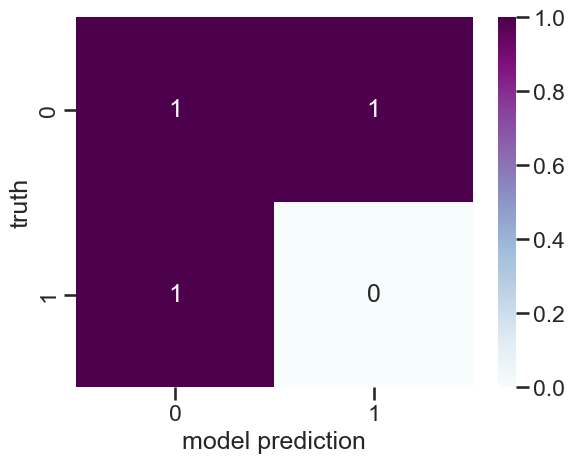

In [428]:
cnf_matrix = metrics.confusion_matrix(y_test, np.rint(predictions))
sns.heatmap(cnf_matrix, annot=True, cmap="BuPu")
plt.xlabel("model prediction")
plt.ylabel("truth")
plt.show()

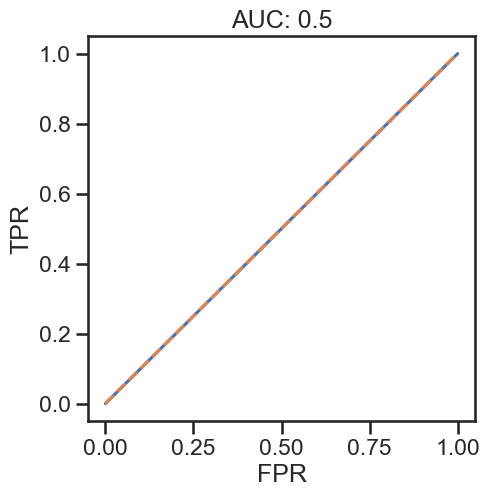

In [204]:
fpr_ch1, tpr_ch1, _ = metrics.roc_curve(y_test, np.rint(predictions))
auc = metrics.roc_auc_score(y_test, np.rint(predictions))
ch_t1_auc = auc
plt.figure(figsize=(5, 5))
plt.plot(fpr_ch1, tpr_ch1)
plt.plot([0, 1], [0, 1], linestyle="dashed")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.title(f"AUC: {np.round(auc, 4)}")
plt.show()

## cross validation

In [199]:
cv = KFold(n_splits=(Y.shape[0])-1, random_state=1, shuffle=True)

In [200]:
chronic_hypertension_firstT_model = LogisticRegression(penalty='l1', solver='liblinear')

In [201]:
scores = cross_val_score(chronic_hypertension_firstT_model, X, Y, scoring='accuracy', cv=cv)
scores

array([0.5, 1. , 1. , 1. , 1. , 0. , 1. , 0. , 0. ])

In [202]:
ch_t1 = np.mean(scores)
ch_t1

0.6111111111111112

# Trimester 2 CH

## case: chronic hypertension control: healthy pregnancy

In [209]:
second_trimester_data["chronic_hypertension"] = np.where(second_trimester_data.disease.str.contains("Chronic-Hypertension"), 1, 0)
chronic_hypertension_secondT = second_trimester_data.drop(["disease"], axis=1)
chronic_hypertension_secondT = second_trimester_data[(second_trimester_data.disease == "Normal-Pregnancy")| (second_trimester_data.disease == "Chronic-Hypertension")]
chronic_hypertension_secondT = chronic_hypertension_secondT.drop(["disease", "gestational_diabetes"], axis=1)
chronic_hypertension_secondT

,0,1,2,3,4,5,6,7,8,9,...,57727,57728,57729,57730,57731,57732,57733,57734,57735,chronic_hypertension
82,0,12,0,0,0,0,0,0,0,0,...,0,8,0,0,0,0,60,0,0,0
87,0,0,0,0,3,0,0,0,0,0,...,0,23,0,0,2,1,90,0,0,0
88,0,0,0,0,0,0,0,0,0,0,...,1,28,0,0,0,12,109,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,5,0,0,0,8,97,0,0,0
98,0,0,0,0,1,0,0,0,0,0,...,0,28,0,0,0,18,97,0,0,0
104,2,1,0,0,0,0,0,0,0,1,...,0,102,0,0,0,13,208,0,0,0
105,0,0,0,0,5,0,0,0,0,0,...,0,33,0,0,0,25,173,0,0,0
121,0,0,0,0,2,0,0,0,0,0,...,0,3,3,0,0,2,27,1,0,0
122,4,0,0,0,0,0,0,0,0,0,...,0,44,0,0,0,59,274,0,0,0
125,0,0,0,0,0,0,0,0,0,0,...,0,88,0,0,0,28,155,7,0,1


## binary lasso reg

In [210]:
X = chronic_hypertension_secondT.loc[:, chronic_hypertension_secondT.columns != "chronic_hypertension"] # use all columns that aren't the outcome for input
Y = chronic_hypertension_secondT["chronic_hypertension"] # use the binary outcome column for Y 

In [211]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.25, random_state=42)

In [212]:
chronic_hypertension_secondT_model = LogisticRegression(penalty='l1', solver='liblinear')
chronic_hypertension_secondT_model.fit(x_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [213]:
predictions = chronic_hypertension_secondT_model.predict(x_test) # we then test it on our held out data

In [214]:
accuracy_score(y_test, predictions)

1.0

In [209]:
chronic_hypertension_secondT_model.coef_

array([[0., 0., 0., ..., 0., 0., 0.]])

## top lasso genes

In [138]:
top_lasso_genes = []
for coef, gene in zip(list(chronic_hypertension_secondT_model.coef_)[0], list(x_train)):
    if (coef != 0):
        top_lasso_genes.append(second_trimester_data[gene]["transcript"])
        chronic_hypertension_secondT_top_lasso_genes = pd.DataFrame(top_lasso_genes, columns = ['gene'])
        
chronic_hypertension_secondT_top_lasso_genes.to_csv("chronic_hypertension_secondT_top_lasso_genes.txt", index=False, sep="\t")
chronic_hypertension_secondT_top_lasso_genes

,gene
0,ENSG00000237973
1,ENSG00000115993
2,ENSG00000163359
3,ENSG00000199994
4,ENSG00000201822
5,ENSG00000137460
6,ENSG00000202198
7,ENSG00000156508
8,ENSG00000252316
9,ENSG00000202354


## plots

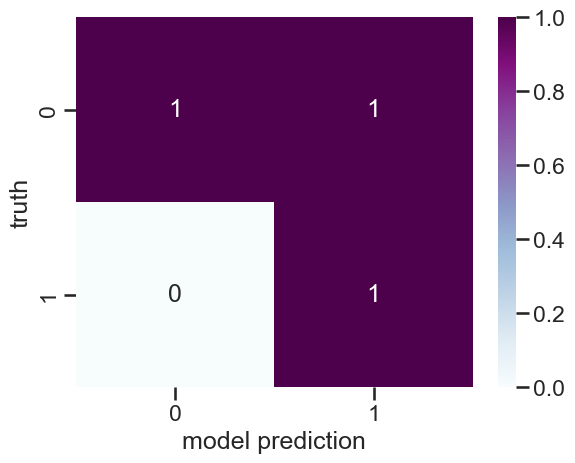

In [443]:
cnf_matrix = metrics.confusion_matrix(y_test, np.rint(predictions))
sns.heatmap(cnf_matrix, annot=True, cmap="BuPu")
plt.xlabel("model prediction")
plt.ylabel("truth")
plt.show()

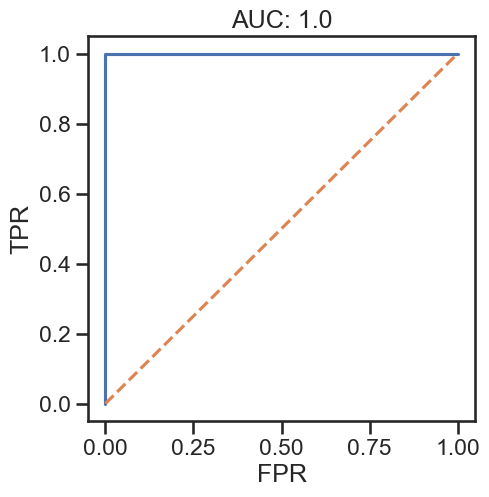

In [215]:
fpr_ch2, tpr_ch2, _ = metrics.roc_curve(y_test, np.rint(predictions))
auc = metrics.roc_auc_score(y_test, np.rint(predictions))
ch_t2_auc = auc
plt.figure(figsize=(5, 5))
plt.plot(fpr_ch2, tpr_ch2)
plt.plot([0, 1], [0, 1], linestyle="dashed")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.title(f"AUC: {np.round(auc, 4)}")
plt.show()

## cross validation

In [210]:
cv = KFold(n_splits=(Y.shape[0])-1, random_state=1, shuffle=True)

In [211]:
chronic_hypertension_secondT_model = LogisticRegression(penalty='l1', solver='liblinear')

In [212]:
scores = cross_val_score(chronic_hypertension_secondT_model, X, Y, scoring='accuracy', cv=cv)
scores

array([0.5, 1. , 1. , 0. , 1. , 0. , 0. , 0. , 1. , 1. ])

In [213]:
ch_t2 = np.mean(scores)
ch_t2

0.55

# Trimester 3 CH

## case: chronic hypertension control: healthy pregnancy

In [216]:
third_trimester_data["chronic_hypertension"] = np.where(third_trimester_data.disease.str.contains("Chronic-Hypertension"), 1, 0)
chronic_hypertension_thirdT = third_trimester_data.drop(["disease"], axis=1)
chronic_hypertension_thirdT = third_trimester_data[(third_trimester_data.disease == "Normal-Pregnancy")| (third_trimester_data.disease == "Chronic-Hypertension")]
chronic_hypertension_thirdT = chronic_hypertension_thirdT.drop(["disease", "preeclampsia", "gestational_diabetes"], axis=1)
chronic_hypertension_thirdT

,0,1,2,3,4,5,6,7,8,9,...,57728,57729,57730,57731,57732,57733,57734,57735,chronic_hypertension,normal_pregnancy
81,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
86,6,0,0,0,0,0,0,0,0,0,...,9,0,0,0,0,40,0,0,0,1
96,0,2,0,0,0,0,0,0,0,0,...,53,0,0,0,3,102,1,0,0,1
101,0,2,0,0,0,0,0,0,0,2,...,272,0,0,0,30,570,0,0,0,1
102,20,2,0,0,0,0,0,7,0,0,...,8,0,0,0,5,96,0,0,0,1
106,0,0,0,0,10,0,0,0,0,0,...,52,1,0,0,26,70,2,0,0,1
107,0,1,0,0,0,0,0,0,0,0,...,130,0,0,0,26,422,0,0,0,1
112,1,0,0,0,0,0,0,0,0,0,...,44,0,0,0,5,205,8,0,0,1
115,0,0,0,0,0,0,0,4,0,0,...,27,0,0,1,5,116,1,0,0,1
127,0,0,0,0,0,0,0,1,0,0,...,59,0,0,0,3,146,0,0,1,0


## binary lasso reg

In [217]:
X = chronic_hypertension_thirdT.loc[:, chronic_hypertension_thirdT.columns != "chronic_hypertension"] # use all columns that aren't the outcome for input
Y = chronic_hypertension_thirdT["chronic_hypertension"] # use the binary outcome column for Y 

In [218]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.25, random_state=42)

In [219]:
chronic_hypertension_thirdT_model = LogisticRegression(penalty='l1', solver='liblinear')
chronic_hypertension_thirdT_model.fit(x_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [220]:
predictions = chronic_hypertension_thirdT_model.predict(x_test) # we then test it on our held out data

In [221]:
accuracy_score(y_test, predictions)

0.6666666666666666

In [450]:
chronic_hypertension_thirdT_model.coef_

array([[0., 0., 0., ..., 0., 0., 0.]])

## top lasso genes

In [262]:
top_lasso_genes = []
for coef, gene in zip(list(chronic_hypertension_thirdT_model.coef_)[0], list(x_train)):
    if (coef != 0):
        top_lasso_genes.append(third_trimester_data[gene]["transcript"])
        chronic_hypertension_thirdT_top_lasso_genes = pd.DataFrame(top_lasso_genes, columns = ['gene'])
        
chronic_hypertension_thirdT_top_lasso_genes.to_csv("chronic_hypertension_thirdT_top_lasso_genes.txt", index=False, sep="\t")
chronic_hypertension_thirdT_top_lasso_genes

,gene
0,ENSG00000163220
1,ENSG00000143546
2,ENSG00000143947
3,ENSG00000115993
4,ENSG00000163359
5,ENSG00000199994
6,ENSG00000201822
7,ENSG00000163736
8,ENSG00000145592
9,ENSG00000231500


## plots

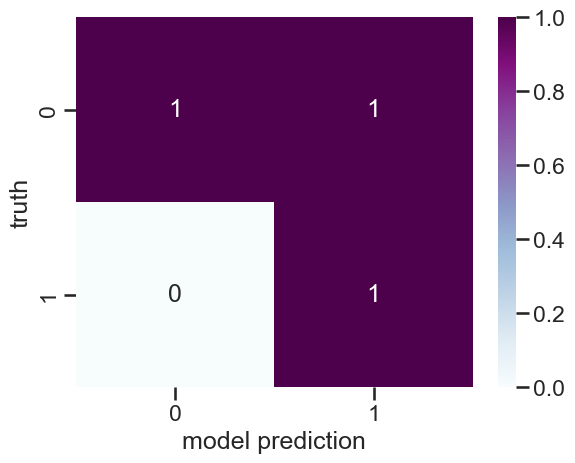

In [451]:
cnf_matrix = metrics.confusion_matrix(y_test, np.rint(predictions))
sns.heatmap(cnf_matrix, annot=True, cmap="BuPu")
plt.xlabel("model prediction")
plt.ylabel("truth")
plt.show()

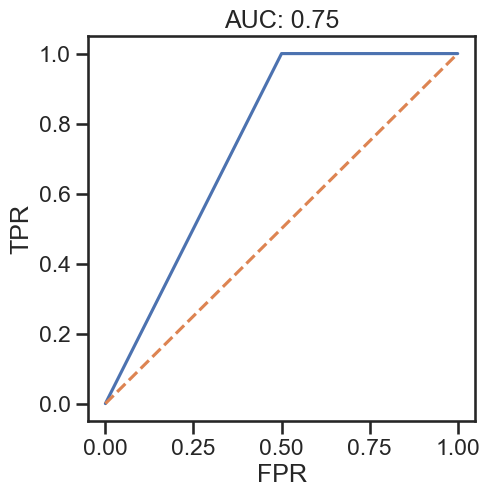

In [222]:
fpr_ch3, tpr_ch3, _ = metrics.roc_curve(y_test, np.rint(predictions))
auc = metrics.roc_auc_score(y_test, np.rint(predictions))
ch_t3_auc = auc
plt.figure(figsize=(5, 5))
plt.plot(fpr_ch3, tpr_ch3)
#plt.plot(FPR, TPR, label=“gestation_diabetes”)
#plt.plot(FPR_prex, TPR_prex, label=“preeclampsia”, color="purple")
#plt.legend()
plt.plot([0, 1], [0, 1], linestyle="dashed")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.title(f"AUC: {np.round(auc, 4)}")
plt.show()

## cross validation

In [220]:
cv = KFold(n_splits=(Y.shape[0])-1, random_state=1, shuffle=True)

In [221]:
chronic_hypertension_thirdT_model = LogisticRegression(penalty='l1', solver='liblinear')

In [222]:
scores = cross_val_score(chronic_hypertension_thirdT_model, X, Y, scoring='accuracy', cv=cv)
scores

array([0.5, 1. , 0. , 1. , 1. , 0. , 1. , 0. , 1. , 0. ])

In [223]:
ch_t3 = np.mean(scores)
ch_t3

0.55

# Trimester 1 NP

## case: pregnancy complications (all diseases) control: healthy pregnancy

In [18]:
first_trimester_data["normal_pregnancy"] = np.where(first_trimester_data.disease.str.contains("Normal-Pregnancy"), 1, 0)
normal_pregnancy_firstT = first_trimester_data.drop(["disease"], axis=1)
normal_pregnancy_firstT

,0,1,2,3,4,5,6,7,8,9,...,57727,57728,57729,57730,57731,57732,57733,57734,57735,normal_pregnancy
2,0,1,0,0,0,0,0,0,0,0,...,0,17,0,0,0,7,132,1,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,47,0,0,0
5,1,1,0,0,6,0,0,0,0,0,...,0,13,2,0,0,2,76,0,0,0
9,1,0,0,0,0,0,0,0,0,0,...,0,47,0,0,0,0,30,0,0,0
20,0,0,0,0,0,0,0,0,0,0,...,0,28,0,0,0,10,111,11,0,0
22,0,2,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,65,0,0,0
25,0,0,0,0,3,0,0,0,0,0,...,0,26,0,0,0,0,160,0,0,0
27,0,0,0,0,0,0,0,0,0,0,...,0,11,0,0,0,0,83,0,0,0
43,0,5,0,0,0,0,0,0,0,1,...,0,24,0,0,0,0,65,0,0,0
44,11,0,0,0,0,0,0,0,0,0,...,0,36,0,0,0,4,95,1,0,0


## binary lasso reg

In [129]:
X = normal_pregnancy_firstT.loc[:, normal_pregnancy_firstT.columns != "normal_pregnancy"] # use all columns that aren't the outcome for input
Y = normal_pregnancy_firstT["normal_pregnancy"] # use the binary outcome column for Y 

In [130]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.25, random_state=42)

In [131]:
normal_pregnancy_firstT_model = LogisticRegression(penalty='l1', solver='liblinear')
normal_pregnancy_firstT_model.fit(x_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [132]:
predictions = normal_pregnancy_firstT_model.predict(x_test) # we then test it on our held out data

In [133]:
accuracy_score(y_test, predictions)

0.8571428571428571

In [134]:
x = normal_pregnancy_firstT_model.coef_
x.size

57736

In [45]:
X

,0,1,2,3,4,5,6,7,8,9,...,57726,57727,57728,57729,57730,57731,57732,57733,57734,57735
2,0,1,0,0,0,0,0,0,0,0,...,63,0,17,0,0,0,7,132,1,0
3,6,0,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,47,0,0
5,1,1,0,0,6,0,0,0,0,0,...,35,0,13,2,0,0,2,76,0,0
9,1,0,0,0,0,0,0,0,0,0,...,19,0,47,0,0,0,0,30,0,0
20,0,0,0,0,0,0,0,0,0,0,...,49,0,28,0,0,0,10,111,11,0
22,0,2,0,0,0,0,0,0,0,0,...,136,0,4,0,0,0,0,65,0,0
25,0,0,0,0,3,0,0,0,0,0,...,62,0,26,0,0,0,0,160,0,0
27,0,0,0,0,0,0,0,0,0,0,...,44,0,11,0,0,0,0,83,0,0
43,0,5,0,0,0,0,0,0,0,1,...,104,0,24,0,0,0,0,65,0,0
44,11,0,0,0,0,0,0,0,0,0,...,95,0,36,0,0,0,4,95,1,0


In [46]:
len(normal_pregnancy_firstT)

25

In [135]:
Y = pd.DataFrame(Y)
Y = Y.reset_index()
Y = Y.drop("index", axis=1)

X = X.reset_index()
X = X.drop("index", axis=1)
X

,0,1,2,3,4,5,6,7,8,9,...,57726,57727,57728,57729,57730,57731,57732,57733,57734,57735
0,0,1,0,0,0,0,0,0,0,0,...,63,0,17,0,0,0,7,132,1,0
1,6,0,0,0,0,0,0,0,0,0,...,5,0,0,0,0,0,0,47,0,0
2,1,1,0,0,6,0,0,0,0,0,...,35,0,13,2,0,0,2,76,0,0
3,1,0,0,0,0,0,0,0,0,0,...,19,0,47,0,0,0,0,30,0,0
4,0,0,0,0,0,0,0,0,0,0,...,49,0,28,0,0,0,10,111,11,0
5,0,2,0,0,0,0,0,0,0,0,...,136,0,4,0,0,0,0,65,0,0
6,0,0,0,0,3,0,0,0,0,0,...,62,0,26,0,0,0,0,160,0,0
7,0,0,0,0,0,0,0,0,0,0,...,44,0,11,0,0,0,0,83,0,0
8,0,5,0,0,0,0,0,0,0,1,...,104,0,24,0,0,0,0,65,0,0
9,11,0,0,0,0,0,0,0,0,0,...,95,0,36,0,0,0,4,95,1,0


In [62]:
import sklearn.linear_model as linear
import pickle as pkl

In [80]:
y_pred = []

for test_ind in range(len(normal_pregnancy_firstT)): 
    
    indices = set(range(len(normal_pregnancy_firstT))) # all possible indices
    X_test, Y_test = X.loc[test_ind], Y.loc[test_ind] # just the test individual 
    X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual 

    logit = linear.LogisticRegression(penalty='l1', solver='liblinear',  max_iter=10000) 
    logit.fit(X_train.values, Y_train.values.reshape(-1,))
    y_pred.append(logit.predict(X_test.values.reshape(1, -1))[0]) # keep the individual predictions in a list 

/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/3478276895.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/3478276895.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/3478276895.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh000

/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/3478276895.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/3478276895.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/3478276895.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh000

In [81]:
y_true = Y["normal_pregnancy"].values
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0])

In [82]:
auc = np.round(metrics.roc_auc_score(y_true, y_pred), 2)
auc

0.75

In [83]:
ps = np.round(metrics.average_precision_score(y_true, y_pred))

In [84]:
precision, recall, _ = metrics.precision_recall_curve(y_true, y_pred, pos_label=1)

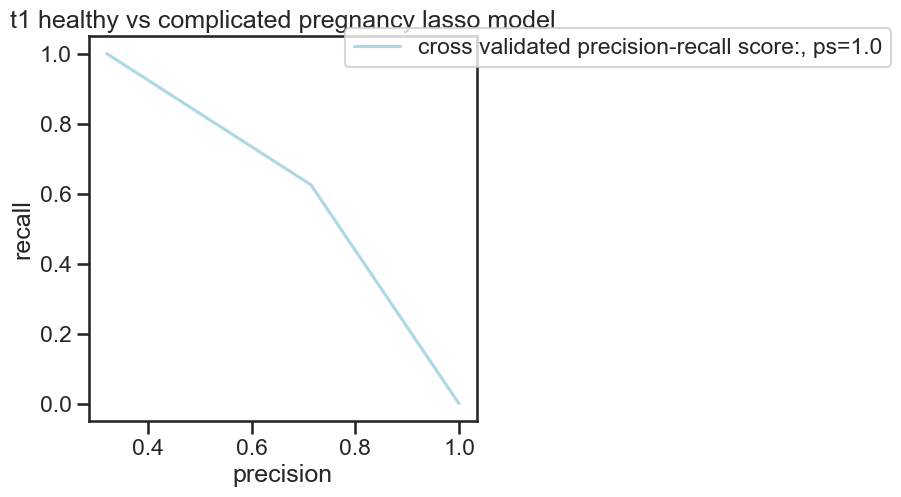

In [89]:
plt.figure(figsize=(5, 5))

plt.plot(precision, recall,  color="lightblue", label=f"cross validated precision-recall score:, ps={ps}")
plt.legend(bbox_to_anchor=(2.1, 1.05))

plt.xlabel("precision")
plt.ylabel("recall")
plt.title("t1 healthy vs complicated pregnancy lasso model")

plt.show()

## bar plots with error bars

In [136]:
y_acc = [] ### keep track of accuracies

for test_ind in range(len(normal_pregnancy_firstT) ): 
    
    indices = set(range(len(normal_pregnancy_firstT))) # all possible indices
    X_test, Y_test = X.loc[test_ind], Y.loc[test_ind] # just the test individual 
    X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual 

    logit = linear.LogisticRegression(penalty='l1', solver='liblinear',  max_iter=10000) 
    logit.fit(X_train.values, Y_train.values.reshape(-1,))
    y_pred = logit.predict(X_test.values.reshape(1, -1))[0]
    
    accuracy = metrics.accuracy_score([Y_test[0]], [y_pred])
    y_acc.append(accuracy) # keep the individual predictions in a list 

/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/298144256.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/298144256.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/298144256.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp

/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/298144256.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/298144256.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/298144256.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp

In [137]:
y_acc_t1 = y_acc
y_acc_t1

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0]

## top lasso genes

In [25]:
first_trimester_data_transcripts = first_trimester_data.drop(["disease", "normal_pregnancy"], axis=1)
first_trimester_data_transcripts = first_trimester_data_transcripts.T
first_trimester_data_transcripts = pd.concat([first_trimester_data_transcripts.reset_index(drop=True), genes["transcript"].reset_index(drop=True)], axis=1)
first_trimester_data_transcripts = first_trimester_data_transcripts.drop(57736)
first_trimester_data_transcripts = first_trimester_data_transcripts.T
first_trimester_data_transcripts
#first_trimester_data

,0,1,2,3,4,5,6,7,8,9,...,57726,57727,57728,57729,57730,57731,57732,57733,57734,57735
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,63.0,0.0,17.0,0.0,0.0,0.0,7.0,132.0,1.0,0.0
3,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0.0,0.0
5,1.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,...,35.0,0.0,13.0,2.0,0.0,0.0,2.0,76.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19.0,0.0,47.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,49.0,0.0,28.0,0.0,0.0,0.0,10.0,111.0,11.0,0.0
22,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,136.0,0.0,4.0,0.0,0.0,0.0,0.0,65.0,0.0,0.0
25,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,62.0,0.0,26.0,0.0,0.0,0.0,0.0,160.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,44.0,0.0,11.0,0.0,0.0,0.0,0.0,83.0,0.0,0.0
43,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,104.0,0.0,24.0,0.0,0.0,0.0,0.0,65.0,0.0,0.0
44,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,95.0,0.0,36.0,0.0,0.0,0.0,4.0,95.0,1.0,0.0


In [47]:
top_lasso_genes = []
coef_list = []
for coef, gene in zip(list(normal_pregnancy_firstT_model.coef_)[0], list(x_train)):
    if (coef != 0):
        coef_list.append(coef)
        top_lasso_genes.append(first_trimester_data_transcripts[int(gene)]["transcript"])
    
normal_pregnancy_firstT_top_lasso_genes = pd.DataFrame(top_lasso_genes, columns = ['gene'])
#normal_pregnancy_firstT_top_lasso_genes.to_csv("normal_pregnancy_firstT_top_lasso_genes.txt", index=False, sep="\t")
normal_pregnancy_firstT_top_lasso_genes['coef'] = coef_list
normal_pregnancy_firstT_top_lasso_genes

,gene,coef
0,ENSG00000225972,-5.322035e-04
1,ENSG00000225630,-1.336532e-03
2,ENSG00000142937,-6.546771e-04
3,ENSG00000122406,-8.899731e-05
4,ENSG00000117289,-7.058972e-07
...,...,...
61,ENSG00000167658,1.141785e-04
62,ENSG00000087086,-3.207406e-05
63,ENSG00000142541,-3.831361e-05
64,ENSG00000142534,-7.378166e-06


In [73]:
## sort by .coef_ and use top genes in presentation
normal_pregnancy_firstT_top_lasso_genes = normal_pregnancy_firstT_top_lasso_genes.sort_values(by='coef', ascending=False)
normal_pregnancy_firstT_top_lasso_genes.head(10)

,gene,coef
17,ENSG00000137460,0.001248
9,ENSG00000201321,0.000785
30,ENSG00000200291,0.000611
56,ENSG00000199568,0.000517
35,ENSG00000161016,0.000410
11,ENSG00000115993,0.000261
45,ENSG00000154146,0.000167
54,ENSG00000199480,0.000149
48,ENSG00000202538,0.000138
36,ENSG00000265735,0.000136


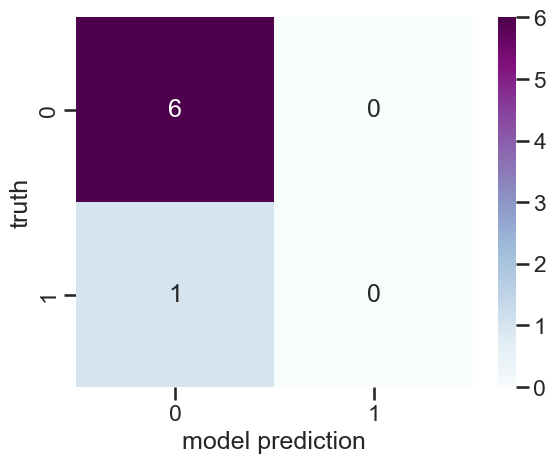

In [48]:
cnf_matrix = metrics.confusion_matrix(y_test, np.rint(predictions))
sns.heatmap(cnf_matrix, annot=True, cmap="BuPu")
plt.xlabel("model prediction")
plt.ylabel("truth")
plt.show()

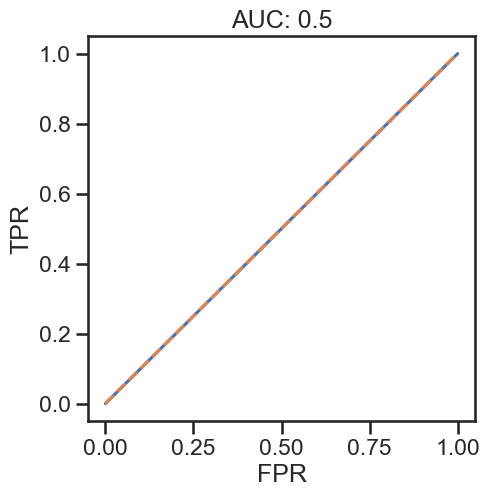

In [229]:
fpr_n1, tpr_n1, _ = metrics.roc_curve(y_test, np.rint(predictions))
auc = metrics.roc_auc_score(y_test, np.rint(predictions))
n_t1_auc = auc
plt.figure(figsize=(5, 5))
plt.plot(fpr_n1, tpr_n1)
plt.plot([0, 1], [0, 1], linestyle="dashed")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.title(f"AUC: {np.round(auc, 4)}")
plt.show()

## cross validation

In [50]:
cv = KFold(n_splits=(Y.shape[0])-1, random_state=1, shuffle=True)

In [51]:
normal_pregnancy_firstT_model = LogisticRegression(penalty='l1', solver='liblinear')

In [52]:
scores = cross_val_score(normal_pregnancy_firstT_model, X, Y, scoring='accuracy', cv=cv)
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0.,
       0., 1., 1., 1., 1., 1., 0.])

In [53]:
n_t1 = np.mean(scores)
n_t1

0.8333333333333334

# Trimester 2 NP

## case: pregnancy complications (all diseases) control: healthy pregnancy

In [90]:
second_trimester_data["normal_pregnancy"] = np.where(second_trimester_data.disease.str.contains("Normal-Pregnancy"), 1, 0)
normal_pregnancy_secondT = second_trimester_data.drop(["disease"], axis=1)
normal_pregnancy_secondT = normal_pregnancy_secondT.drop("transcript", axis=0)
normal_pregnancy_secondT

,0,1,2,3,4,5,6,7,8,9,...,57727,57728,57729,57730,57731,57732,57733,57734,57735,normal_pregnancy
0,3,9,0,0,0,0,0,0,0,0,...,0,45,3,0,0,0,135,0,0,0
4,19,0,0,0,0,0,0,0,0,0,...,0,41,0,0,0,0,20,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,35,0,0,0,1,112,7,0,0
13,1,0,0,0,0,0,0,0,0,3,...,0,56,0,0,0,21,171,0,0,0
23,9,0,0,0,0,0,0,0,0,2,...,0,31,0,0,0,1,107,0,0,0
24,0,8,0,0,0,0,0,0,0,0,...,0,38,0,0,0,0,98,0,0,0
31,0,0,0,0,3,0,0,0,0,0,...,0,31,0,0,0,13,135,0,0,0
34,1,0,0,0,8,0,0,0,0,0,...,0,38,1,0,0,6,74,2,0,0
42,0,5,0,0,0,0,0,0,0,0,...,0,72,0,0,0,0,110,0,0,0
48,0,0,0,0,2,0,0,0,0,0,...,0,16,0,0,0,10,76,0,0,0


## binary lasso reg

In [120]:
X = normal_pregnancy_secondT.loc[:, normal_pregnancy_secondT.columns != "normal_pregnancy"] # use all columns that aren't the outcome for input
Y = normal_pregnancy_secondT["normal_pregnancy"] # use the binary outcome column for Y 

In [121]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.25, random_state=42)

In [122]:
normal_pregnancy_secondT_model = LogisticRegression(penalty='l1', solver='liblinear')
normal_pregnancy_secondT_model.fit(x_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [123]:
predictions = normal_pregnancy_secondT_model.predict(x_test) # we then test it on our held out data

In [124]:
accuracy_score(y_test, predictions)

0.42857142857142855

In [125]:
normal_pregnancy_secondT_model.coef_

array([[0., 0., 0., ..., 0., 0., 0.]])

In [126]:
Y = pd.DataFrame(Y)
Y = Y.reset_index()
Y = Y.drop("index", axis=1)

X = X.reset_index()
X = X.drop("index", axis=1)

In [100]:
y_pred = []

for test_ind in range(len(normal_pregnancy_secondT)): 
    
    indices = set(range(len(normal_pregnancy_secondT))) # all possible indices
    X_test, Y_test = X.loc[test_ind], Y.loc[test_ind] # just the test individual 
    X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual 

    logit = linear.LogisticRegression(penalty='l1', solver='liblinear',  max_iter=10000) 
    logit.fit(X_train.values, Y_train.values.reshape(-1,))
    y_pred.append(logit.predict(X_test.values.reshape(1, -1))[0]) # keep the individual predictions in a list 

/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/1576798843.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/1576798843.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/1576798843.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh000

/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/1576798843.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/1576798843.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/1576798843.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh000

In [101]:
y_true = Y["normal_pregnancy"].values
auc = np.round(metrics.roc_auc_score(y_true, y_pred), 2)
auc

0.43

In [102]:
ps = np.round(metrics.average_precision_score(y_true, y_pred))
precision, recall, _ = metrics.precision_recall_curve(y_true, y_pred, pos_label=1)

In [103]:
precision, recall, _ = metrics.precision_recall_curve(y_true, y_pred, pos_label=1)

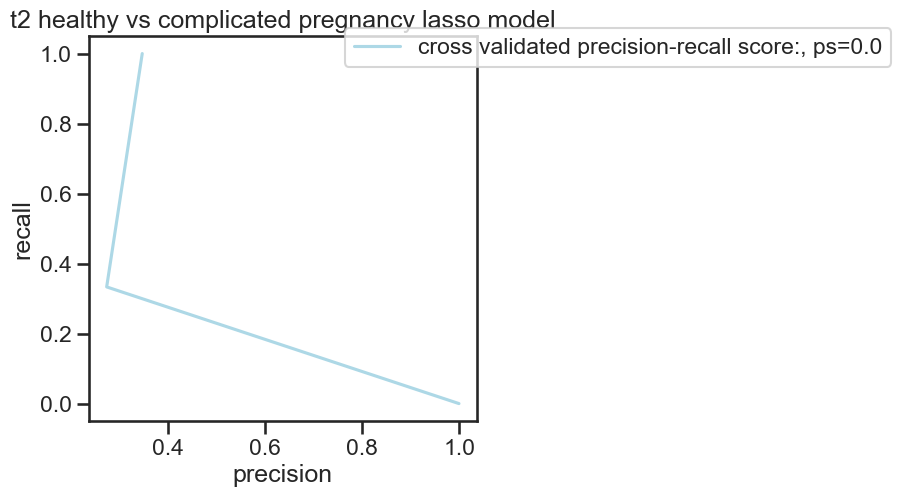

In [104]:
plt.figure(figsize=(5, 5))

plt.plot(precision, recall,  color="lightblue", label=f"cross validated precision-recall score:, ps={ps}")
plt.legend(bbox_to_anchor=(2.1, 1.05))

plt.xlabel("precision")
plt.ylabel("recall")
plt.title("t2 healthy vs complicated pregnancy lasso model")

plt.show()

In [127]:
y_acc = [] ### keep track of accuracies

for test_ind in range(len(normal_pregnancy_secondT) ): 
    
    indices = set(range(len(normal_pregnancy_secondT))) # all possible indices
    X_test, Y_test = X.loc[test_ind], Y.loc[test_ind] # just the test individual 
    X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual 

    logit = linear.LogisticRegression(penalty='l1', solver='liblinear',  max_iter=10000) 
    logit.fit(X_train.values, Y_train.values.reshape(-1,))
    y_pred = logit.predict(X_test.values.reshape(1, -1))[0]
    
    accuracy = metrics.accuracy_score([Y_test[0]], [y_pred])
    y_acc.append(accuracy) # keep the individual predictions in a list 

/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/2623091873.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/2623091873.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/2623091873.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh000

/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/2623091873.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/2623091873.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/2623091873.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh000

In [128]:
y_acc_t2 = y_acc
y_acc_t2

[0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0]

## top lasso genes

In [61]:
second_trimester_data_transcripts = second_trimester_data.drop(["disease","normal_pregnancy"], axis=1)
second_trimester_data_transcripts = second_trimester_data_transcripts.T
second_trimester_data_transcripts = second_trimester_data_transcripts.drop("transcript", axis=1)
second_trimester_data_transcripts = pd.concat([second_trimester_data_transcripts.reset_index(drop=True), genes["transcript"].reset_index(drop=True)], axis=1)
second_trimester_data_transcripts = second_trimester_data_transcripts.drop(57736)
second_trimester_data_transcripts = second_trimester_data_transcripts.T
second_trimester_data_transcripts

,0,1,2,3,4,5,6,7,8,9,...,57726,57727,57728,57729,57730,57731,57732,57733,57734,57735
0,3,9,0,0,0,0,0,0,0,0,...,172,0,45,3,0,0,0,135,0,0
4,19,0,0,0,0,0,0,0,0,0,...,49,0,41,0,0,0,0,20,0,0
10,0,0,0,0,0,0,0,0,0,0,...,49,0,35,0,0,0,1,112,7,0
13,1,0,0,0,0,0,0,0,0,3,...,110,0,56,0,0,0,21,171,0,0
23,9,0,0,0,0,0,0,0,0,2,...,3,0,31,0,0,0,1,107,0,0
24,0,8,0,0,0,0,0,0,0,0,...,66,0,38,0,0,0,0,98,0,0
31,0,0,0,0,3,0,0,0,0,0,...,54,0,31,0,0,0,13,135,0,0
34,1,0,0,0,8,0,0,0,0,0,...,51,0,38,1,0,0,6,74,2,0
42,0,5,0,0,0,0,0,0,0,0,...,53,0,72,0,0,0,0,110,0,0
48,0,0,0,0,2,0,0,0,0,0,...,65,0,16,0,0,0,10,76,0,0


In [62]:
# top_lasso_genes = []
# for coef, gene in zip(list(normal_pregnancy_secondT_model.coef_)[0], list(x_train)):
#     if (coef != 0):
#         #print(first_trimester_data_transcripts[int(gene)]["transcript"])
#         top_lasso_genes.append(second_trimester_data_transcripts[int(gene)]["transcript"])
#         normal_pregnancy_secondT_top_lasso_genes = pd.DataFrame(top_lasso_genes, columns = ['gene'])
        
# normal_pregnancy_secondT_top_lasso_genes.to_csv("normal_pregnancy_secondT_top_lasso_genes.txt", index=False, sep="\t")
# normal_pregnancy_secondT_top_lasso_genes

top_lasso_genes = []
coef_list = []
for coef, gene in zip(list(normal_pregnancy_secondT_model.coef_)[0], list(x_train)):
    if (coef != 0):
        coef_list.append(coef)
        top_lasso_genes.append(second_trimester_data_transcripts[int(gene)]["transcript"])
    
normal_pregnancy_secondT_top_lasso_genes = pd.DataFrame(top_lasso_genes, columns = ['gene'])
#normal_pregnancy_secondT_top_lasso_genes.to_csv("normal_pregnancy_secondT_top_lasso_genes.txt", index=False, sep="\t")
normal_pregnancy_secondT_top_lasso_genes['coef'] = coef_list
normal_pregnancy_secondT_top_lasso_genes

,gene,coef
0,ENSG00000163220,-0.002602
1,ENSG00000115993,-0.000381
2,ENSG00000163359,0.000309
3,ENSG00000269028,-0.004619
4,ENSG00000201822,-0.000386
5,ENSG00000231500,0.000621
6,ENSG00000202198,0.000190
7,ENSG00000156508,-0.000210
8,ENSG00000075624,0.000326
9,ENSG00000202354,-0.000052


In [63]:
## sort by .coef_ and use top genes in presentation
normal_pregnancy_secondT_top_lasso_genes = normal_pregnancy_secondT_top_lasso_genes.sort_values(by='coef', ascending=False)
normal_pregnancy_secondT_top_lasso_genes.head(5)

,gene,coef
12,ENSG00000070756,0.002078
5,ENSG00000231500,0.000621
17,ENSG00000166710,0.000555
14,ENSG00000244734,0.000340
8,ENSG00000075624,0.000326


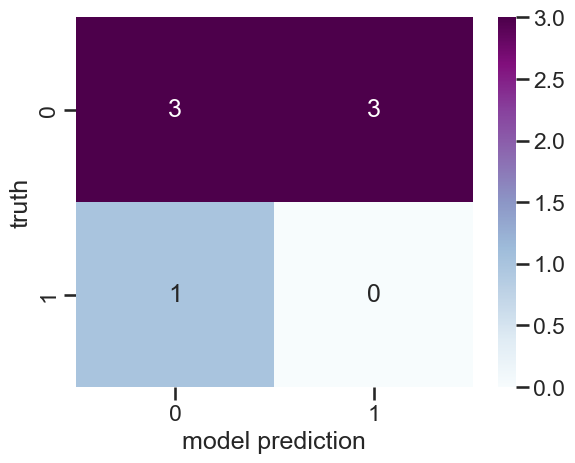

In [62]:
cnf_matrix = metrics.confusion_matrix(y_test, np.rint(predictions))
sns.heatmap(cnf_matrix, annot=True, cmap="BuPu")
plt.xlabel("model prediction")
plt.ylabel("truth")
plt.show()

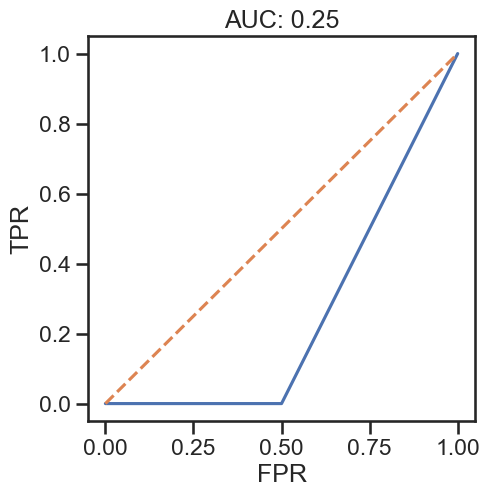

In [236]:
fpr_n2, tpr_n2, _ = metrics.roc_curve(y_test, np.rint(predictions))
auc = metrics.roc_auc_score(y_test, np.rint(predictions))
n_t2_auc = auc
plt.figure(figsize=(5, 5))
plt.plot(fpr_n2, tpr_n2)
plt.plot([0, 1], [0, 1], linestyle="dashed")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.title(f"AUC: {np.round(auc, 4)}")
plt.show()

## cross validation

In [243]:
cv = KFold(n_splits=(Y.shape[0])-1, random_state=1, shuffle=True)

In [244]:
normal_pregnancy_secondT_model = LogisticRegression(penalty='l1', solver='liblinear')

In [245]:
scores = cross_val_score(normal_pregnancy_secondT_model, X, Y, scoring='accuracy', cv=cv)
scores

array([0.5, 0. , 1. , 0. , 1. , 0. , 0. , 1. , 0. , 1. , 0. , 1. , 1. ,
       1. , 0. , 0. , 0. , 0. , 1. , 0. , 1. , 0. , 0. , 1. , 0. ])

In [246]:
n_t2 = np.mean(scores)
n_t2

0.42

# Trimester 3 NP

## case: pregnancy complications (all diseases) control: healthy pregnancy

In [107]:
third_trimester_data["normal_pregnancy"] = np.where(third_trimester_data.disease.str.contains("Normal-Pregnancy"), 1, 0)
normal_pregnancy_thirdT = third_trimester_data.drop(["disease"], axis=1)
normal_pregnancy_thirdT = normal_pregnancy_thirdT.drop("transcript", axis=0)
normal_pregnancy_thirdT

,0,1,2,3,4,5,6,7,8,9,...,57727,57728,57729,57730,57731,57732,57733,57734,57735,normal_pregnancy
11,0,0,0,0,0,0,0,3,0,0,...,0,5,0,0,0,3,46,1,0,0
12,0,0,1,0,5,0,0,2,0,2,...,0,35,0,0,1,9,127,0,0,0
14,0,4,0,0,0,0,0,0,0,0,...,0,42,0,0,0,0,213,3,0,0
15,1,0,0,0,2,0,0,0,0,2,...,2,59,0,0,0,11,123,0,0,0
29,0,1,0,0,0,5,1,2,0,0,...,4,83,0,0,4,13,74,10,0,0
33,0,0,0,0,0,0,0,0,0,0,...,0,51,0,0,0,6,175,0,0,0
35,34,2,0,0,0,0,0,0,0,4,...,0,11,0,0,0,1,109,1,0,0
36,0,0,0,0,0,0,0,0,0,2,...,8,47,0,0,0,1,122,0,0,0
40,1,0,0,0,0,0,0,0,0,0,...,0,20,0,0,0,3,71,0,0,0
46,2,8,0,0,0,0,0,0,0,0,...,0,29,0,0,0,0,116,0,0,0


## binary lasso reg

In [138]:
X = normal_pregnancy_thirdT.loc[:, normal_pregnancy_thirdT.columns != "normal_pregnancy"] # use all columns that aren't the outcome for input
Y = normal_pregnancy_thirdT["normal_pregnancy"] # use the binary outcome column for Y 

In [139]:
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.25, random_state=42)

In [140]:
normal_pregnancy_thirdT_model = LogisticRegression(penalty='l1', solver='liblinear')
normal_pregnancy_thirdT_model.fit(x_train, y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [141]:
predictions = normal_pregnancy_thirdT_model.predict(x_test) # we then test it on our held out data

In [142]:
accuracy_score(y_test, predictions)

0.42857142857142855

In [143]:
Y = pd.DataFrame(Y)
Y = Y.reset_index()
Y = Y.drop("index", axis=1)

X = X.reset_index()
X = X.drop("index", axis=1)

In [144]:
y_acc = [] ### keep track of accuracies

for test_ind in range(len(normal_pregnancy_thirdT) ): 
    
    indices = set(range(len(normal_pregnancy_thirdT))) # all possible indices
    X_test, Y_test = X.loc[test_ind], Y.loc[test_ind] # just the test individual 
    X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual 

    logit = linear.LogisticRegression(penalty='l1', solver='liblinear',  max_iter=10000) 
    logit.fit(X_train.values, Y_train.values.reshape(-1,))
    y_pred = logit.predict(X_test.values.reshape(1, -1))[0]
    
    accuracy = metrics.accuracy_score([Y_test[0]], [y_pred])
    y_acc.append(accuracy) # keep the individual predictions in a list 

/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/2039109223.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/2039109223.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/2039109223.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh000

/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/2039109223.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/2039109223.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh0000gp/T/ipykernel_32505/2039109223.py:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X_train, Y_train = X.loc[indices - set([test_ind])], Y.loc[indices - set([test_ind])]  # everyone but the test individual
/var/folders/sb/np6l2_0j1797w6wrlkcy0yzh000

In [145]:
y_acc_t3 = y_acc
y_acc_t3

[1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [147]:
# make a dataframe 
category1 = ["trimester 1"] * len(y_acc_t1)
category2 = ["trimester 2"] * len(y_acc_t2)
category3 = ["trimester 3"] * len(y_acc_t3)

combined_accuracy = y_acc_t1 + list(y_acc_t3) + list(y_acc_t3)
combined_categories = category1 + category2 + category3

df = pd.DataFrame(zip(combined_accuracy, combined_categories), columns = ["accuracy", "trimester"])
df

,accuracy,trimester
0,1.0,trimester 1
1,1.0,trimester 1
2,1.0,trimester 1
3,1.0,trimester 1
4,1.0,trimester 1
...,...,...
70,1.0,trimester 3
71,1.0,trimester 3
72,1.0,trimester 3
73,1.0,trimester 3


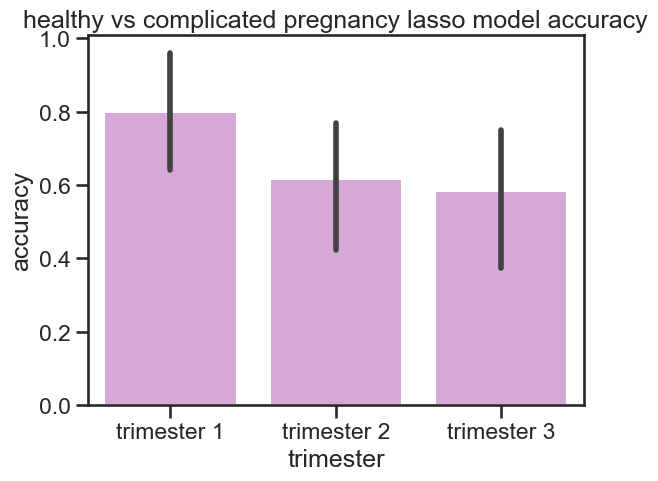

In [150]:
sns.barplot(x="trimester", y="accuracy", data=df, color="plum")
plt.title("healthy vs complicated pregnancy lasso model accuracy")
plt.show()

## top lasso genes

In [70]:
third_trimester_data_transcripts = third_trimester_data.drop(["disease","normal_pregnancy"], axis=1)
third_trimester_data_transcripts = third_trimester_data_transcripts.T
third_trimester_data_transcripts = third_trimester_data_transcripts.drop("transcript", axis=1)
third_trimester_data_transcripts = pd.concat([third_trimester_data_transcripts.reset_index(drop=True), genes["transcript"].reset_index(drop=True)], axis=1)
third_trimester_data_transcripts = third_trimester_data_transcripts.drop(57736)
third_trimester_data_transcripts = third_trimester_data_transcripts.T
third_trimester_data_transcripts

,0,1,2,3,4,5,6,7,8,9,...,57726,57727,57728,57729,57730,57731,57732,57733,57734,57735
11,0,0,0,0,0,0,0,3,0,0,...,52,0,5,0,0,0,3,46,1,0
12,0,0,1,0,5,0,0,2,0,2,...,85,0,35,0,0,1,9,127,0,0
14,0,4,0,0,0,0,0,0,0,0,...,127,0,42,0,0,0,0,213,3,0
15,1,0,0,0,2,0,0,0,0,2,...,115,2,59,0,0,0,11,123,0,0
29,0,1,0,0,0,5,1,2,0,0,...,98,4,83,0,0,4,13,74,10,0
33,0,0,0,0,0,0,0,0,0,0,...,72,0,51,0,0,0,6,175,0,0
35,34,2,0,0,0,0,0,0,0,4,...,36,0,11,0,0,0,1,109,1,0
36,0,0,0,0,0,0,0,0,0,2,...,51,8,47,0,0,0,1,122,0,0
40,1,0,0,0,0,0,0,0,0,0,...,110,0,20,0,0,0,3,71,0,0
46,2,8,0,0,0,0,0,0,0,0,...,98,0,29,0,0,0,0,116,0,0


In [71]:
# top_lasso_genes = []
# for coef, gene in zip(list(normal_pregnancy_thirdT_model.coef_)[0], list(x_train)):
#     if (coef != 0):
#         #print(first_trimester_data_transcripts[int(gene)]["transcript"])
#         top_lasso_genes.append(third_trimester_data_transcripts[int(gene)]["transcript"])
#         normal_pregnancy_thirdT_top_lasso_genes = pd.DataFrame(top_lasso_genes, columns = ['gene'])
        
# normal_pregnancy_thirdT_top_lasso_genes.to_csv("normal_pregnancy_thirdT_top_lasso_genes.txt", index=False, sep="\t")
# normal_pregnancy_thirdT_top_lasso_genes

top_lasso_genes = []
coef_list = []
for coef, gene in zip(list(normal_pregnancy_thirdT_model.coef_)[0], list(x_train)):
    if (coef != 0):
        coef_list.append(coef)
        top_lasso_genes.append(third_trimester_data_transcripts[int(gene)]["transcript"])
    
normal_pregnancy_thirdT_top_lasso_genes = pd.DataFrame(top_lasso_genes, columns = ['gene'])
#normal_pregnancy_thirdT_top_lasso_genes.to_csv("normal_pregnancy_thirdT_top_lasso_genes.txt", index=False, sep="\t")
normal_pregnancy_thirdT_top_lasso_genes['coef'] = coef_list
normal_pregnancy_thirdT_top_lasso_genes

,gene,coef
0,ENSG00000237973,-0.000966
1,ENSG00000143546,-0.000304
2,ENSG00000155657,-0.004348
3,ENSG00000163359,0.000827
4,ENSG00000199994,0.000469
5,ENSG00000201822,0.000768
6,ENSG00000163737,0.001879
7,ENSG00000163736,0.000013
8,ENSG00000202198,0.000997
9,ENSG00000075624,0.000482


In [72]:
## sort by .coef_ and use top genes in presentation
normal_pregnancy_thirdT_top_lasso_genes = normal_pregnancy_thirdT_top_lasso_genes.sort_values(by='coef', ascending=False)
normal_pregnancy_thirdT_top_lasso_genes.head(5)

,gene,coef
6,ENSG00000163737,0.001879
16,ENSG00000138293,0.001394
8,ENSG00000202198,0.000997
3,ENSG00000163359,0.000827
5,ENSG00000201822,0.000768


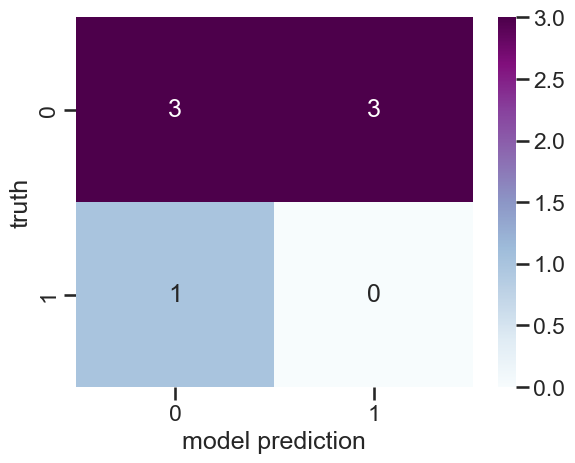

In [81]:
cnf_matrix = metrics.confusion_matrix(y_test, np.rint(predictions))
sns.heatmap(cnf_matrix, annot=True, cmap="BuPu")
plt.xlabel("model prediction")
plt.ylabel("truth")
plt.show()

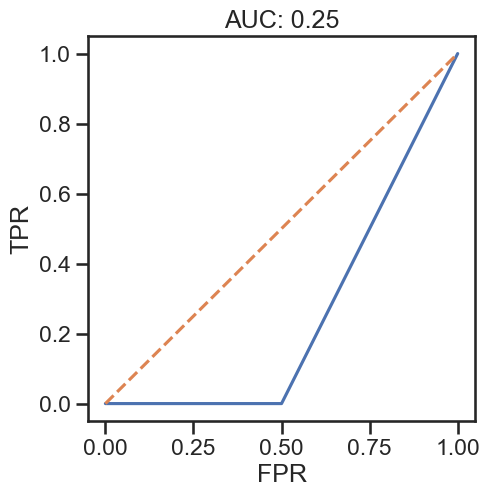

In [244]:
fpr_n3, tpr_n3, _ = metrics.roc_curve(y_test, np.rint(predictions))
auc = metrics.roc_auc_score(y_test, np.rint(predictions))
n_t3_auc = auc
plt.figure(figsize=(5, 5))
plt.plot(fpr_n3, tpr_n3)
plt.plot([0, 1], [0, 1], linestyle="dashed")
plt.ylabel("TPR")
plt.xlabel("FPR")
plt.title(f"AUC: {np.round(auc, 4)}")
plt.show()

# cross validation

In [83]:
cv = KFold(n_splits=(Y.shape[0])-1, random_state=1, shuffle=True)

In [84]:
normal_pregnancy_thirdT_model = LogisticRegression(penalty='l1', solver='liblinear')

In [85]:
scores = cross_val_score(normal_pregnancy_thirdT_model, X, Y, scoring='accuracy', cv=cv)
scores

array([0.5, 0. , 1. , 1. , 0. , 1. , 0. , 1. , 0. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 0. , 1. , 1. , 0. , 0. , 1. , 1. , 1. ])

In [86]:
n_t3 = np.mean(scores)
n_t3

0.6875

# cv scores plot

In [225]:
cv_data = {'cv score': [p_t1, p_t2, p_t3, gd_t1, gd_t2, gd_t3, ch_t1, ch_t2, ch_t3, n_t1, n_t2, n_t3],
           'trimester': ['t1', 't2', 't3', 't1', 't2', 't3', 't1', 't2', 't3', "t1", "t2", "t3"],
           'disease': ['preeclampsia', 'preeclampsia', 'preeclampsia', 
                       'gestational diabetes', 'gestational diabetes', 'gestational diabetes',
                       'chronic hypertension', 'chronic hypertension', 'chronic hypertension',
                       'normal pregnancy', 'normal pregnancy', 'normal pregnancy',]}

cv_df = pd.DataFrame(cv_data)
cv_df

,cv score,trimester,disease
0,0.800000,t1,preeclampsia
1,0.500000,t2,preeclampsia
2,0.531250,t3,preeclampsia
3,0.678571,t1,gestational diabetes
4,0.433333,t2,gestational diabetes
5,0.428571,t3,gestational diabetes
6,0.611111,t1,chronic hypertension
7,0.550000,t2,chronic hypertension
8,0.550000,t3,chronic hypertension
9,0.833333,t1,normal pregnancy


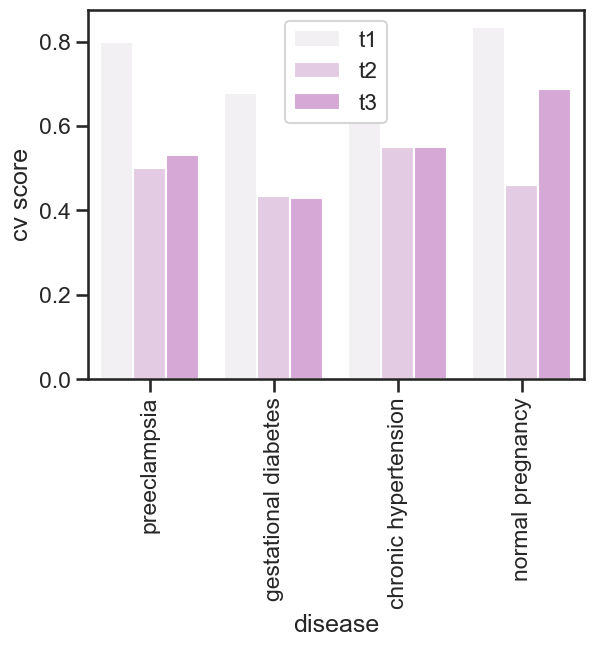

In [247]:
sns.barplot(data = cv_df, x = 'disease', y = 'cv score', color = 'plum', hue = 'trimester', ci = None,)
plt.xticks(rotation=90)
plt.legend(loc='upper center')

In [122]:
auc_data = {'auc': [p_t1_auc, p_t2_auc, p_t3_auc, gd_t1_auc, gd_t2_auc, gd_t3_auc, ch_t1_auc, ch_t2_auc, ch_t3_auc, n_t1_auc, n_t2_auc, n_t3_auc],
           'trimester': ['t1', 't2', 't3', 't1', 't2', 't3', 't1', 't2', 't3', 't1', 't2', 't3'],
           'disease': ['preeclampsia', 'preeclampsia', 'preeclampsia', 
                       'gestational diabetes', 'gestational diabetes', 'gestational diabetes',
                       'chronic hypertension', 'chronic hypertension', 'chronic hypertension',
                       'normal pregnancy', 'normal pregnancy', 'normal pregnancy']}

auc_df = pd.DataFrame(auc_data)
auc_df

,auc,trimester,disease
0,0.833333,t1,preeclampsia
1,0.666667,t2,preeclampsia
2,0.833333,t3,preeclampsia
3,0.500000,t1,gestational diabetes
4,0.500000,t2,gestational diabetes
5,0.500000,t3,gestational diabetes
6,0.500000,t1,chronic hypertension
7,0.750000,t2,chronic hypertension
8,0.750000,t3,chronic hypertension
9,0.500000,t1,normal pregnancy


(array([0, 1, 2, 3]),
 [Text(0, 0, 'preeclampsia'),
  Text(1, 0, 'gestational diabetes'),
  Text(2, 0, 'chronic hypertension'),
  Text(3, 0, 'normal pregnancy')])

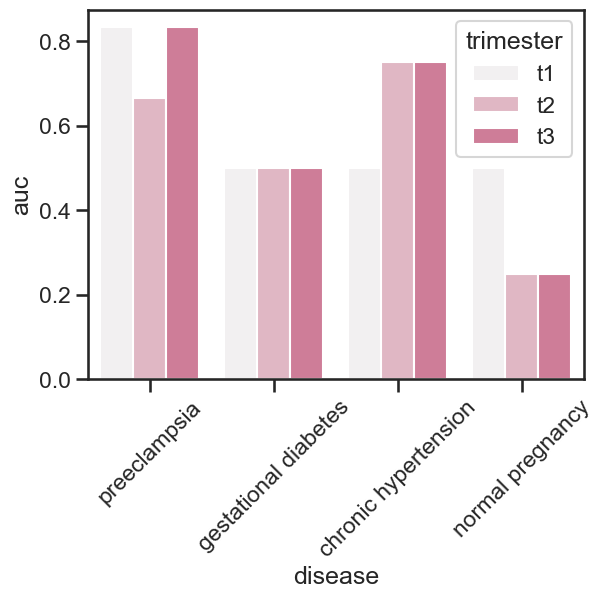

In [123]:
sns.barplot(data = auc_df, x = 'disease', y = 'auc', color = 'palevioletred', hue = 'trimester', ci = None,)
plt.xticks(rotation=45)

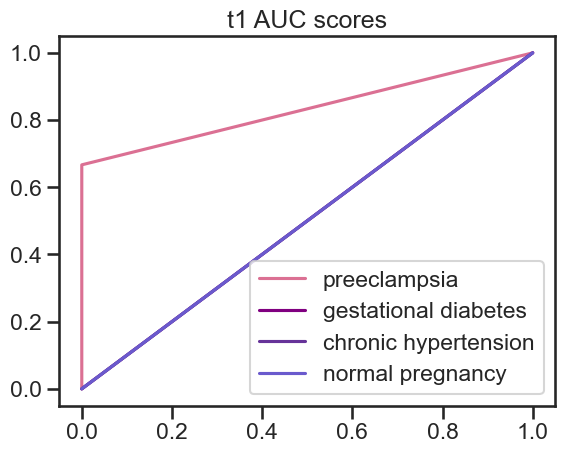

In [254]:
#plt.plot(FPR, TPR, label=“gestation_diabetes”)
plt.plot(fpr_p1, tpr_p1, label="preeclampsia", color="palevioletred")
plt.plot(fpr_gd1, tpr_gd1, label="gestational diabetes", color="purple")
plt.plot(fpr_ch1, tpr_ch1, label="chronic hypertension", color="rebeccapurple")
plt.plot(fpr_n1, tpr_n1, label="normal pregnancy", color="slateblue")
plt.title("t1 AUC scores")
plt.legend()

plt.plot(fpr_p2, tpr_p2, label="preeclampsia", color="palevioletred")
plt.plot(fpr_gd2, tpr_gd2, label="gestational diabetes", color="purple")
plt.plot(fpr_ch2, tpr_ch2, label="chronic hypertension", color="rebeccapurple")
plt.plot(fpr_n2, tpr_n2, label="normal pregnancy", color="slateblue")
plt.title("t2 AUC scores")
plt.legend()

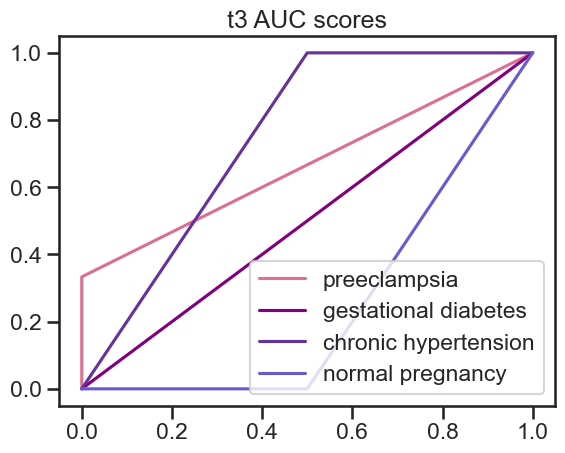

In [256]:
plt.plot(fpr_p3, tpr_p3, label="preeclampsia", color="palevioletred")
plt.plot(fpr_gd3, tpr_gd3, label="gestational diabetes", color="purple")
plt.plot(fpr_ch3, tpr_ch3, label="chronic hypertension", color="rebeccapurple")
plt.plot(fpr_n3, tpr_n3, label="normal pregnancy", color="slateblue")
plt.title("t3 AUC scores")
plt.legend()